In [3]:
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, CyclicLR
from functools import partial
%matplotlib inline

cv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [5]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


100%|██████████| 170498071/170498071 [00:01<00:00, 103436123.46it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [6]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [7]:
# calculate mean and standard deviation

m = np.mean(train_set.data, axis=(0,1,2))
print(m/255)

s = np.std(train_set.data, axis=(0, 1, 2))
print(s/255)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [8]:
mean = m/255
sdev = s/255

In [9]:
SEED = 101

BATCH = 1024

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [10]:
from google.colab import files

In [11]:
# def plot_misclassified_images(images, true_labels, predicted_labels, grid_cols):
#     grid_rows = (len(images) - 1) // grid_cols + 1
#     fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(12, 12))

#     for i in range(len(images)):
#         row = i // grid_cols
#         col = i % grid_cols

#         image = images[i]
#         label_true = true_labels[i].item()
#         label_pred = predicted_labels[i].item()

#         axs[row, col].imshow(image, cmap='gray')
#         axs[row, col].set_title(f'True: {label_true}, Predicted: {label_pred}')
#         axs[row, col].axis('off')

#     plt.tight_layout()
#     plt.show()

In [12]:
def plot_misclassified_images(incorrect_examples, incorrect_labels, incorrect_preds):
    fig = plt.figure(figsize=(20, 8))

    for idx in np.arange(10):
      ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
      #std = np.array([0.229, 0.224, 0.225])
      #mean = np.array([0.485, 0.456, 0.406])
      img = incorrect_examples[idx][idx]
      img = img/2 + 0.5
      img = np.clip(img, 0, 1)
      imshow(img)
      ax.set_title(f"{classes[pred[idx]]}: x%\n (label: {classes[target[idx]]})",
      color=("green" if pred[idx]==target[idx].item() else "red"))

In [13]:
incorrect_examples = []
incorrect_labels = []
incorrect_preds = []

In [14]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1, test=False, test_loader=None, scheduler=None):
    counter = 0
    model_name = None
    model.train() # set the train mode

    test_acc_window = [0,0,0]

    # iterate over for `epochs` epochs and keep storing valuable info

    for epoch in range(epochs):
      correct = processed = train_loss = 0
    #   if scheduler:
    #     scheduler.step()

      print(f"\n epoch num ================================= {epoch+1} out of {epochs} epochs")

      pbar = tqdm(train_loader)

      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device) # move data to `device`

          optimizer.zero_grad() # zero out the gradients to avoid accumulating them over loops

          output = model(data) # get the model's predictions

          loss = F.nll_loss(output, target) # calculate Negative Log Likelihood loss using ground truth labels and the model's predictions

          train_loss += loss.item() # add up the train loss

          loss.backward() # boom ! The magic function to perform backpropagation and calculate the gradients

          optimizer.step() # take 1 step for the optimizer and update the weights

          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

          correct += pred.eq(target.view_as(pred)).sum().item() #  compare and see how many predictions are coorect and then add up the count

          processed += len(data) # total processed data size

      acc = 100 * correct/processed

      train_losses.append(train_loss)

      train_accuracy.append(acc)

      if scheduler:
        print("\n\n\t\t\tLast LR -->", scheduler.get_last_lr())
        scheduler.step()

      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


      train_loss /= len(train_loader.dataset)
      print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct,
                                                              len(train_loader.dataset),
                                                              correct * 100 / len(train_loader.dataset)))

      if test: # moving to evaluation
          model.eval() # set the correct mode

          correct = test_loss = 0

          with torch.no_grad(): # to disable gradient calculation with no_grad context

              for data, target in test_loader:

                  data, target = data.to(device), target.to(device)

                  output = model(data)

                  test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

                  correct += pred.eq(target.view_as(pred)).sum().item()




          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          curr_test_acc = 100. * correct / len(test_loader.dataset)
          test_accuracy.append(curr_test_acc)

          test_acc_window[counter % 3] = curr_test_acc
          counter = counter + 1

          if curr_test_acc >= 85.0:
              print(f"\nStoring misclassified images at: {curr_test_acc}% at epoch: {epoch}")
              misclassified_mask = ((pred == target.view_as(pred)) == False).view(-1)

              if misclassified_mask.numel():
                  incorrect_examples.append(data[misclassified_mask].squeeze().cpu().numpy())
                  incorrect_labels.append(target[misclassified_mask].cpu().numpy()) #the corresponding target to the misclassified image
                  incorrect_preds.append(pred[misclassified_mask].squeeze().cpu().numpy()) #the corresponiding predicted class of the misclassified image


          if curr_test_acc > 85.0:
              if all(x > 85.0 for x in test_acc_window):
                  model_name = f"./85_crossed_{counter}.pth"
                  torch.save(model, model_name)


          print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))
    if model_name:
        files.download(model_name)

In [15]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):

    # Plot for accuracy

    plt.figure(figsize=(10, 5))

    plt.plot(train_accuracy, label='Training Accuracy', color='blue')

    plt.plot(test_accuracy, label='Test Accuracy', color='orange')

    plt.title('Accuracy')

    plt.xlabel('Epoch')

    plt.ylabel('Accuracy')

    plt.legend(loc='lower right')

    plt.grid(True)

    plt.show()



    # Plot for loss

    plt.figure(figsize=(10, 5))

    plt.plot(train_losses, label='Training Loss', color='green')

    plt.plot(test_losses, label='Test Loss', color='red')

    plt.title('Loss')

    plt.xlabel('Epoch')

    plt.ylabel('Loss')

    plt.legend(loc='upper right')

    plt.grid(True)

    plt.show()

In [16]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [21]:
# transforms

# here changed CoarseDropout's p to 0.25 from default 0.5, along with minor change in MedianBlur value and HSV' value
train_transforms = A.Compose([
                                A.Normalize(mean=mean, std=sdev, always_apply=True),
                                A.HorizontalFlip(p=0.5),
                                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15,rotate_limit=30, p=0.2),
                                A.CoarseDropout(max_holes=1, p=0.3, max_height=16,
                                                max_width=16, min_holes=1, min_height=16,
                                                min_width=16, fill_value=mean),
                                A.ColorJitter(brightness=0.2, contrast=0.2,saturation=0.2, p=0.2),
                                ToTensorV2()
                                       ])

test_transforms = A.Compose([
                            A.Normalize(mean=mean, std=sdev, always_apply=True),
                            ToTensorV2()
                                    ])


In [22]:

# data sets with transforms

train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets

train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([1024, 3, 32, 32])
torch.Size([1024])


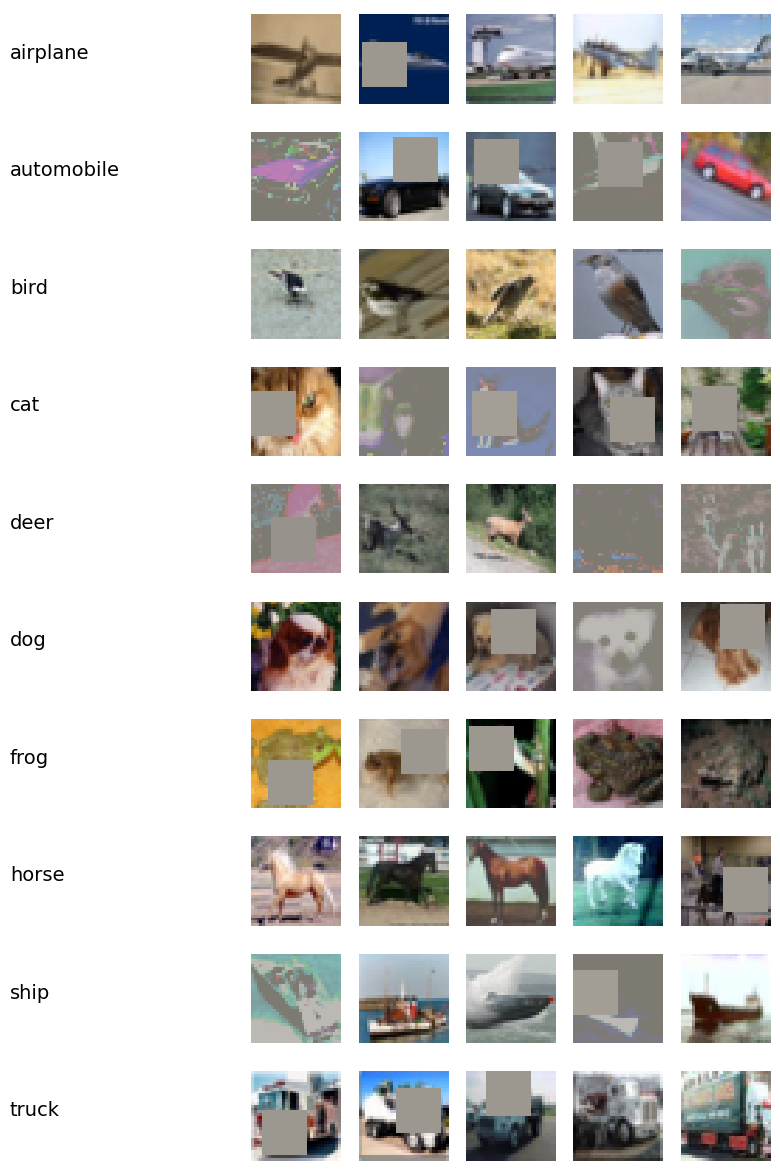

In [23]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)

  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]

  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category.
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [24]:
class Net_new_2(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            cv(3, 16, 3, padding=1),
            relu(),
            bn(16),
            cv(16, 32, 3, dilation=1, groups=1, padding=1, stride=1),
            relu(),
            bn(32),
            cv(32, 32, 3, dilation=1, groups=1, padding=1, stride=2),
            relu(),
            bn(32),
            nn.Dropout2d(0.05)
        )

        self.block2 = nn.Sequential(
            cv(32, 64, 3, padding=1, dilation=1, groups=1),
            relu(),
            bn(64),
            cv(64, 32, 1),  # 1x1
            # relu(),
            # bn(32),
            cv(32, 64, 3, dilation=1, padding=1, groups=16),
            relu(),
            bn(64),
            cv(64, 64, 1),  # 1x1
            cv(64, 64, 3, padding=2, dilation=1, groups=16, stride=2),
            relu(),
            bn(64),
            nn.Dropout2d(0.08)
        )

        self.block3 = nn.Sequential(
            cv(64, 64, 3, dilation=1, padding=1, groups=32, stride=1),
            relu(),
            bn(64),
            cv(64, 64, 1),  # 1x1
            cv(64, 96, 3, padding=1, groups=1),
            relu(),
            bn(96),
            cv(96, 64, 1),  # 1x1
            cv(64, 64, 3, padding=2, dilation=2, stride=2),
            relu(),
            bn(64),
            nn.Dropout2d(0.09)
            )

        self.block4 = nn.Sequential(
            cv(64, 96, 3, padding=1, groups=32, stride=1, dilation=2),
            bn(96),
            relu(),
            cv(96, 64, 1),  # 1x1
            cv(64, 64, 3, groups=64, padding=1, dilation=1), # depthwise (a)
            cv(64, 32, 1), # pointwise for preceding depthwise (b)
            bn(32),
            relu(),
            cv(32, 48, 3, dilation=2,padding=2, stride=2),
            relu(),
            bn(48)
            )
        self.final_block = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            cv(48, 10, 1),  # 1x1
        )


    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.final_block(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


model2 = Net_new_2().to(device)
summary(model2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,608
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 16, 16]           9,216
              ReLU-8           [-1, 32, 16, 16]               0
       BatchNorm2d-9           [-1, 32, 16, 16]              64
        Dropout2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          18,432
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
           Conv2d-14           [-1, 32,

In [25]:
# model2 = Net_new_2().to(device)

## worked
# optimizer = optim.SGD(model2.parameters(), lr=0.0001, momentum=0.9, nesterov=True,weight_decay=0.003)

# cyclic_lr = CyclicLR(optimizer=optimizer,base_lr=0.0005, max_lr=0.02,step_size_up=20, step_size_down=20,mode="triangular")

# train_losses = []
# train_accuracy = []
# test_losses = []
# test_accuracy = []

# train_eval_model(model2, train_loader, optimizer, device, epochs=200, test=True, test_loader=test_loader, scheduler=cyclic_lr)

In [27]:
model2 = Net_new_2().to(device)

optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9, nesterov=True)

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

train_eval_model(model2, train_loader, optimizer, device, epochs=70, test=True, test_loader=test_loader, scheduler=None)


 epoch num ================================= 1 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]


			Train metrics: accuracy: 10673/50000 (21.3460%)



	Test metrics: average loss: 1.8550, accuracy: 3193/10000 (31.93000%)


 epoch num ================================= 2 out of 70 epochs


100%|██████████| 49/49 [00:12<00:00,  3.90it/s]


			Train metrics: accuracy: 17671/50000 (35.3420%)



	Test metrics: average loss: 1.5060, accuracy: 4431/10000 (44.31000%)


 epoch num ================================= 3 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]


			Train metrics: accuracy: 20937/50000 (41.8740%)



	Test metrics: average loss: 1.3761, accuracy: 4918/10000 (49.18000%)


 epoch num ================================= 4 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]


			Train metrics: accuracy: 22595/50000 (45.1900%)



	Test metrics: average loss: 1.3214, accuracy: 5175/10000 (51.75000%)


 epoch num ================================= 5 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.32it/s]


			Train metrics: accuracy: 24186/50000 (48.3720%)



	Test metrics: average loss: 1.2214, accuracy: 5565/10000 (55.65000%)


 epoch num ================================= 6 out of 70 epochs


100%|██████████| 49/49 [00:11<00:00,  4.15it/s]


			Train metrics: accuracy: 25292/50000 (50.5840%)



	Test metrics: average loss: 1.2111, accuracy: 5622/10000 (56.22000%)


 epoch num ================================= 7 out of 70 epochs


100%|██████████| 49/49 [00:08<00:00,  5.57it/s]


			Train metrics: accuracy: 26276/50000 (52.5520%)



	Test metrics: average loss: 1.1210, accuracy: 5968/10000 (59.68000%)


 epoch num ================================= 8 out of 70 epochs


100%|██████████| 49/49 [00:11<00:00,  4.45it/s]


			Train metrics: accuracy: 27024/50000 (54.0480%)



	Test metrics: average loss: 1.0841, accuracy: 6129/10000 (61.29000%)


 epoch num ================================= 9 out of 70 epochs


100%|██████████| 49/49 [00:11<00:00,  4.25it/s]


			Train metrics: accuracy: 27959/50000 (55.9180%)



	Test metrics: average loss: 1.1492, accuracy: 5967/10000 (59.67000%)


 epoch num ================================= 10 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]


			Train metrics: accuracy: 28807/50000 (57.6140%)



	Test metrics: average loss: 1.0038, accuracy: 6435/10000 (64.35000%)


 epoch num ================================= 11 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]


			Train metrics: accuracy: 29527/50000 (59.0540%)



	Test metrics: average loss: 0.9715, accuracy: 6533/10000 (65.33000%)


 epoch num ================================= 12 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.17it/s]


			Train metrics: accuracy: 29867/50000 (59.7340%)



	Test metrics: average loss: 0.9446, accuracy: 6647/10000 (66.47000%)


 epoch num ================================= 13 out of 70 epochs


100%|██████████| 49/49 [00:08<00:00,  5.61it/s]


			Train metrics: accuracy: 30890/50000 (61.7800%)



	Test metrics: average loss: 1.0488, accuracy: 6317/10000 (63.17000%)


 epoch num ================================= 14 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.16it/s]


			Train metrics: accuracy: 31239/50000 (62.4780%)



	Test metrics: average loss: 0.8973, accuracy: 6853/10000 (68.53000%)


 epoch num ================================= 15 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]


			Train metrics: accuracy: 31658/50000 (63.3160%)



	Test metrics: average loss: 0.9044, accuracy: 6826/10000 (68.26000%)


 epoch num ================================= 16 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.77it/s]


			Train metrics: accuracy: 32237/50000 (64.4740%)



	Test metrics: average loss: 0.8262, accuracy: 7082/10000 (70.82000%)


 epoch num ================================= 17 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.10it/s]


			Train metrics: accuracy: 32731/50000 (65.4620%)



	Test metrics: average loss: 0.8309, accuracy: 7095/10000 (70.95000%)


 epoch num ================================= 18 out of 70 epochs


100%|██████████| 49/49 [00:08<00:00,  5.59it/s]


			Train metrics: accuracy: 32994/50000 (65.9880%)



	Test metrics: average loss: 0.8009, accuracy: 7177/10000 (71.77000%)


 epoch num ================================= 19 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


			Train metrics: accuracy: 33241/50000 (66.4820%)



	Test metrics: average loss: 0.8230, accuracy: 7101/10000 (71.01000%)


 epoch num ================================= 20 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]


			Train metrics: accuracy: 33734/50000 (67.4680%)



	Test metrics: average loss: 0.7753, accuracy: 7298/10000 (72.98000%)


 epoch num ================================= 21 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.58it/s]


			Train metrics: accuracy: 33780/50000 (67.5600%)



	Test metrics: average loss: 0.7685, accuracy: 7293/10000 (72.93000%)


 epoch num ================================= 22 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.05it/s]


			Train metrics: accuracy: 34202/50000 (68.4040%)



	Test metrics: average loss: 0.8055, accuracy: 7238/10000 (72.38000%)


 epoch num ================================= 23 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.44it/s]


			Train metrics: accuracy: 34472/50000 (68.9440%)



	Test metrics: average loss: 0.7360, accuracy: 7433/10000 (74.33000%)


 epoch num ================================= 24 out of 70 epochs


100%|██████████| 49/49 [00:08<00:00,  5.55it/s]


			Train metrics: accuracy: 34673/50000 (69.3460%)



	Test metrics: average loss: 0.7356, accuracy: 7384/10000 (73.84000%)


 epoch num ================================= 25 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]


			Train metrics: accuracy: 34837/50000 (69.6740%)



	Test metrics: average loss: 0.7250, accuracy: 7496/10000 (74.96000%)


 epoch num ================================= 26 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]


			Train metrics: accuracy: 35232/50000 (70.4640%)



	Test metrics: average loss: 0.7183, accuracy: 7496/10000 (74.96000%)


 epoch num ================================= 27 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]


			Train metrics: accuracy: 35500/50000 (71.0000%)



	Test metrics: average loss: 0.7105, accuracy: 7550/10000 (75.50000%)


 epoch num ================================= 28 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]


			Train metrics: accuracy: 35533/50000 (71.0660%)



	Test metrics: average loss: 0.7126, accuracy: 7551/10000 (75.51000%)


 epoch num ================================= 29 out of 70 epochs


100%|██████████| 49/49 [00:08<00:00,  5.63it/s]


			Train metrics: accuracy: 35728/50000 (71.4560%)



	Test metrics: average loss: 0.6925, accuracy: 7614/10000 (76.14000%)


 epoch num ================================= 30 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.07it/s]


			Train metrics: accuracy: 35961/50000 (71.9220%)



	Test metrics: average loss: 0.6832, accuracy: 7635/10000 (76.35000%)


 epoch num ================================= 31 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]


			Train metrics: accuracy: 36142/50000 (72.2840%)



	Test metrics: average loss: 0.6920, accuracy: 7631/10000 (76.31000%)


 epoch num ================================= 32 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]


			Train metrics: accuracy: 36338/50000 (72.6760%)



	Test metrics: average loss: 0.6738, accuracy: 7682/10000 (76.82000%)


 epoch num ================================= 33 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]


			Train metrics: accuracy: 36335/50000 (72.6700%)



	Test metrics: average loss: 0.6841, accuracy: 7686/10000 (76.86000%)


 epoch num ================================= 34 out of 70 epochs


100%|██████████| 49/49 [00:08<00:00,  5.63it/s]


			Train metrics: accuracy: 36444/50000 (72.8880%)



	Test metrics: average loss: 0.6885, accuracy: 7705/10000 (77.05000%)


 epoch num ================================= 35 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.11it/s]


			Train metrics: accuracy: 36646/50000 (73.2920%)



	Test metrics: average loss: 0.6535, accuracy: 7760/10000 (77.60000%)


 epoch num ================================= 36 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


			Train metrics: accuracy: 36719/50000 (73.4380%)



	Test metrics: average loss: 0.6358, accuracy: 7789/10000 (77.89000%)


 epoch num ================================= 37 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.54it/s]


			Train metrics: accuracy: 36895/50000 (73.7900%)



	Test metrics: average loss: 0.6483, accuracy: 7748/10000 (77.48000%)


 epoch num ================================= 38 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.85it/s]


			Train metrics: accuracy: 37152/50000 (74.3040%)



	Test metrics: average loss: 0.6445, accuracy: 7769/10000 (77.69000%)


 epoch num ================================= 39 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.15it/s]


			Train metrics: accuracy: 37333/50000 (74.6660%)



	Test metrics: average loss: 0.6364, accuracy: 7835/10000 (78.35000%)


 epoch num ================================= 40 out of 70 epochs


100%|██████████| 49/49 [00:08<00:00,  5.66it/s]


			Train metrics: accuracy: 37485/50000 (74.9700%)



	Test metrics: average loss: 0.6322, accuracy: 7847/10000 (78.47000%)


 epoch num ================================= 41 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]


			Train metrics: accuracy: 37436/50000 (74.8720%)



	Test metrics: average loss: 0.6176, accuracy: 7850/10000 (78.50000%)


 epoch num ================================= 42 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


			Train metrics: accuracy: 37685/50000 (75.3700%)



	Test metrics: average loss: 0.6201, accuracy: 7902/10000 (79.02000%)


 epoch num ================================= 43 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.80it/s]


			Train metrics: accuracy: 37665/50000 (75.3300%)



	Test metrics: average loss: 0.6269, accuracy: 7846/10000 (78.46000%)


 epoch num ================================= 44 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]


			Train metrics: accuracy: 37713/50000 (75.4260%)



	Test metrics: average loss: 0.6293, accuracy: 7831/10000 (78.31000%)


 epoch num ================================= 45 out of 70 epochs


100%|██████████| 49/49 [00:08<00:00,  5.56it/s]


			Train metrics: accuracy: 37911/50000 (75.8220%)



	Test metrics: average loss: 0.6029, accuracy: 7925/10000 (79.25000%)


 epoch num ================================= 46 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.08it/s]


			Train metrics: accuracy: 37922/50000 (75.8440%)



	Test metrics: average loss: 0.6235, accuracy: 7873/10000 (78.73000%)


 epoch num ================================= 47 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]


			Train metrics: accuracy: 38078/50000 (76.1560%)



	Test metrics: average loss: 0.6049, accuracy: 7962/10000 (79.62000%)


 epoch num ================================= 48 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]


			Train metrics: accuracy: 38150/50000 (76.3000%)



	Test metrics: average loss: 0.6000, accuracy: 7953/10000 (79.53000%)


 epoch num ================================= 49 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


			Train metrics: accuracy: 38256/50000 (76.5120%)



	Test metrics: average loss: 0.6064, accuracy: 7944/10000 (79.44000%)


 epoch num ================================= 50 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]


			Train metrics: accuracy: 38266/50000 (76.5320%)



	Test metrics: average loss: 0.6157, accuracy: 7953/10000 (79.53000%)


 epoch num ================================= 51 out of 70 epochs


100%|██████████| 49/49 [00:08<00:00,  5.48it/s]


			Train metrics: accuracy: 38517/50000 (77.0340%)



	Test metrics: average loss: 0.5964, accuracy: 7966/10000 (79.66000%)


 epoch num ================================= 52 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]


			Train metrics: accuracy: 38553/50000 (77.1060%)



	Test metrics: average loss: 0.6173, accuracy: 7926/10000 (79.26000%)


 epoch num ================================= 53 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]


			Train metrics: accuracy: 38602/50000 (77.2040%)



	Test metrics: average loss: 0.6215, accuracy: 7883/10000 (78.83000%)


 epoch num ================================= 54 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


			Train metrics: accuracy: 38617/50000 (77.2340%)



	Test metrics: average loss: 0.5825, accuracy: 8040/10000 (80.40000%)


 epoch num ================================= 55 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


			Train metrics: accuracy: 38619/50000 (77.2380%)



	Test metrics: average loss: 0.5902, accuracy: 8050/10000 (80.50000%)


 epoch num ================================= 56 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.28it/s]


			Train metrics: accuracy: 38817/50000 (77.6340%)



	Test metrics: average loss: 0.6057, accuracy: 7934/10000 (79.34000%)


 epoch num ================================= 57 out of 70 epochs


100%|██████████| 49/49 [00:08<00:00,  5.70it/s]


			Train metrics: accuracy: 39020/50000 (78.0400%)



	Test metrics: average loss: 0.5969, accuracy: 7989/10000 (79.89000%)


 epoch num ================================= 58 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


			Train metrics: accuracy: 38916/50000 (77.8320%)



	Test metrics: average loss: 0.6004, accuracy: 7960/10000 (79.60000%)


 epoch num ================================= 59 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.78it/s]


			Train metrics: accuracy: 38945/50000 (77.8900%)



	Test metrics: average loss: 0.5808, accuracy: 8028/10000 (80.28000%)


 epoch num ================================= 60 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


			Train metrics: accuracy: 39000/50000 (78.0000%)



	Test metrics: average loss: 0.5886, accuracy: 8026/10000 (80.26000%)


 epoch num ================================= 61 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.83it/s]


			Train metrics: accuracy: 39173/50000 (78.3460%)



	Test metrics: average loss: 0.5773, accuracy: 8047/10000 (80.47000%)


 epoch num ================================= 62 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.36it/s]


			Train metrics: accuracy: 39286/50000 (78.5720%)



	Test metrics: average loss: 0.5839, accuracy: 8034/10000 (80.34000%)


 epoch num ================================= 63 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.23it/s]


			Train metrics: accuracy: 39430/50000 (78.8600%)



	Test metrics: average loss: 0.5779, accuracy: 8049/10000 (80.49000%)


 epoch num ================================= 64 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


			Train metrics: accuracy: 39513/50000 (79.0260%)



	Test metrics: average loss: 0.5754, accuracy: 8089/10000 (80.89000%)


 epoch num ================================= 65 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.78it/s]


			Train metrics: accuracy: 39253/50000 (78.5060%)



	Test metrics: average loss: 0.5876, accuracy: 8008/10000 (80.08000%)


 epoch num ================================= 66 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


			Train metrics: accuracy: 39460/50000 (78.9200%)



	Test metrics: average loss: 0.5708, accuracy: 8042/10000 (80.42000%)


 epoch num ================================= 67 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


			Train metrics: accuracy: 39425/50000 (78.8500%)



	Test metrics: average loss: 0.5826, accuracy: 8035/10000 (80.35000%)


 epoch num ================================= 68 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.42it/s]


			Train metrics: accuracy: 39558/50000 (79.1160%)



	Test metrics: average loss: 0.5667, accuracy: 8101/10000 (81.01000%)


 epoch num ================================= 69 out of 70 epochs


100%|██████████| 49/49 [00:09<00:00,  5.09it/s]


			Train metrics: accuracy: 39569/50000 (79.1380%)



	Test metrics: average loss: 0.5709, accuracy: 8098/10000 (80.98000%)


 epoch num ================================= 70 out of 70 epochs


100%|██████████| 49/49 [00:10<00:00,  4.69it/s]


			Train metrics: accuracy: 39677/50000 (79.3540%)



	Test metrics: average loss: 0.5717, accuracy: 8056/10000 (80.56000%)



In [28]:
optimizer = optim.SGD(model2.parameters(), lr=0.0001, momentum=0.9, nesterov=True,weight_decay=0.001)

cyclic_lr = CyclicLR(optimizer=optimizer,base_lr=0.0001, max_lr=0.01,step_size_up=30, step_size_down=30, mode="triangular2")

train_eval_model(model2, train_loader, optimizer, device, epochs=120, test=True, test_loader=test_loader, scheduler=cyclic_lr)


 epoch num ================================= 1 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]



			Last LR --> [0.0001]

			Train metrics: accuracy: 31815/50000 (63.6300%)



	Test metrics: average loss: 1.0697, accuracy: 7515/10000 (75.15000%)


 epoch num ================================= 2 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]



			Last LR --> [0.00042999999999999885]

			Train metrics: accuracy: 35862/50000 (71.7240%)



	Test metrics: average loss: 0.7051, accuracy: 7737/10000 (77.37000%)


 epoch num ================================= 3 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.85it/s]



			Last LR --> [0.0007600000000000021]

			Train metrics: accuracy: 37553/50000 (75.1060%)



	Test metrics: average loss: 0.5828, accuracy: 7951/10000 (79.51000%)


 epoch num ================================= 4 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.50it/s]



			Last LR --> [0.001090000000000001]

			Train metrics: accuracy: 38439/50000 (76.8780%)



	Test metrics: average loss: 0.5539, accuracy: 8082/10000 (80.82000%)


 epoch num ================================= 5 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.10it/s]



			Last LR --> [0.0014199999999999998]

			Train metrics: accuracy: 39187/50000 (78.3740%)



	Test metrics: average loss: 0.5443, accuracy: 8117/10000 (81.17000%)


 epoch num ================================= 6 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.73it/s]



			Last LR --> [0.0017499999999999987]

			Train metrics: accuracy: 39559/50000 (79.1180%)



	Test metrics: average loss: 0.5361, accuracy: 8184/10000 (81.84000%)


 epoch num ================================= 7 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.84it/s]



			Last LR --> [0.0020800000000000016]

			Train metrics: accuracy: 39701/50000 (79.4020%)



	Test metrics: average loss: 0.5356, accuracy: 8167/10000 (81.67000%)


 epoch num ================================= 8 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.82it/s]



			Last LR --> [0.0024100000000000007]

			Train metrics: accuracy: 39920/50000 (79.8400%)



	Test metrics: average loss: 0.5308, accuracy: 8209/10000 (82.09000%)


 epoch num ================================= 9 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.90it/s]



			Last LR --> [0.0027399999999999994]

			Train metrics: accuracy: 40117/50000 (80.2340%)



	Test metrics: average loss: 0.5351, accuracy: 8195/10000 (81.95000%)


 epoch num ================================= 10 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.41it/s]



			Last LR --> [0.0030699999999999985]

			Train metrics: accuracy: 40092/50000 (80.1840%)



	Test metrics: average loss: 0.5267, accuracy: 8270/10000 (82.70000%)


 epoch num ================================= 11 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.16it/s]



			Last LR --> [0.0034000000000000015]

			Train metrics: accuracy: 40253/50000 (80.5060%)



	Test metrics: average loss: 0.5325, accuracy: 8213/10000 (82.13000%)


 epoch num ================================= 12 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.90it/s]



			Last LR --> [0.0037300000000000002]

			Train metrics: accuracy: 40298/50000 (80.5960%)



	Test metrics: average loss: 0.5312, accuracy: 8224/10000 (82.24000%)


 epoch num ================================= 13 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.004059999999999999]

			Train metrics: accuracy: 40351/50000 (80.7020%)



	Test metrics: average loss: 0.5298, accuracy: 8220/10000 (82.20000%)


 epoch num ================================= 14 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.76it/s]



			Last LR --> [0.004390000000000003]

			Train metrics: accuracy: 40362/50000 (80.7240%)



	Test metrics: average loss: 0.5255, accuracy: 8252/10000 (82.52000%)


 epoch num ================================= 15 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]



			Last LR --> [0.004720000000000002]

			Train metrics: accuracy: 40570/50000 (81.1400%)



	Test metrics: average loss: 0.5332, accuracy: 8205/10000 (82.05000%)


 epoch num ================================= 16 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.26it/s]



			Last LR --> [0.005050000000000001]

			Train metrics: accuracy: 40585/50000 (81.1700%)



	Test metrics: average loss: 0.5383, accuracy: 8178/10000 (81.78000%)


 epoch num ================================= 17 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.34it/s]



			Last LR --> [0.005379999999999999]

			Train metrics: accuracy: 40552/50000 (81.1040%)



	Test metrics: average loss: 0.5271, accuracy: 8230/10000 (82.30000%)


 epoch num ================================= 18 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.80it/s]



			Last LR --> [0.005709999999999998]

			Train metrics: accuracy: 40586/50000 (81.1720%)



	Test metrics: average loss: 0.5215, accuracy: 8266/10000 (82.66000%)


 epoch num ================================= 19 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.76it/s]



			Last LR --> [0.006040000000000002]

			Train metrics: accuracy: 40731/50000 (81.4620%)



	Test metrics: average loss: 0.5249, accuracy: 8232/10000 (82.32000%)


 epoch num ================================= 20 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.80it/s]



			Last LR --> [0.006370000000000001]

			Train metrics: accuracy: 40564/50000 (81.1280%)



	Test metrics: average loss: 0.5296, accuracy: 8231/10000 (82.31000%)


 epoch num ================================= 21 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.88it/s]



			Last LR --> [0.006699999999999999]

			Train metrics: accuracy: 40692/50000 (81.3840%)



	Test metrics: average loss: 0.5283, accuracy: 8241/10000 (82.41000%)


 epoch num ================================= 22 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.81it/s]



			Last LR --> [0.007030000000000002]

			Train metrics: accuracy: 40807/50000 (81.6140%)



	Test metrics: average loss: 0.5250, accuracy: 8249/10000 (82.49000%)


 epoch num ================================= 23 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.49it/s]



			Last LR --> [0.007360000000000001]

			Train metrics: accuracy: 40699/50000 (81.3980%)



	Test metrics: average loss: 0.5352, accuracy: 8223/10000 (82.23000%)


 epoch num ================================= 24 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.43it/s]



			Last LR --> [0.007690000000000001]

			Train metrics: accuracy: 40607/50000 (81.2140%)



	Test metrics: average loss: 0.5352, accuracy: 8214/10000 (82.14000%)


 epoch num ================================= 25 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.84it/s]



			Last LR --> [0.008019999999999998]

			Train metrics: accuracy: 40768/50000 (81.5360%)



	Test metrics: average loss: 0.5210, accuracy: 8219/10000 (82.19000%)


 epoch num ================================= 26 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Last LR --> [0.008350000000000002]

			Train metrics: accuracy: 40841/50000 (81.6820%)



	Test metrics: average loss: 0.5254, accuracy: 8253/10000 (82.53000%)


 epoch num ================================= 27 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]



			Last LR --> [0.00868]

			Train metrics: accuracy: 40794/50000 (81.5880%)



	Test metrics: average loss: 0.5225, accuracy: 8266/10000 (82.66000%)


 epoch num ================================= 28 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.83it/s]



			Last LR --> [0.009009999999999999]

			Train metrics: accuracy: 40763/50000 (81.5260%)



	Test metrics: average loss: 0.5301, accuracy: 8211/10000 (82.11000%)


 epoch num ================================= 29 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.78it/s]



			Last LR --> [0.009340000000000003]

			Train metrics: accuracy: 40751/50000 (81.5020%)



	Test metrics: average loss: 0.5362, accuracy: 8254/10000 (82.54000%)


 epoch num ================================= 30 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.30it/s]




			Last LR --> [0.009670000000000002]

			Train metrics: accuracy: 40701/50000 (81.4020%)

	Test metrics: average loss: 0.5392, accuracy: 8240/10000 (82.40000%)


 epoch num ================================= 31 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.35it/s]



			Last LR --> [0.01]

			Train metrics: accuracy: 40821/50000 (81.6420%)



	Test metrics: average loss: 0.5266, accuracy: 8266/10000 (82.66000%)


 epoch num ================================= 32 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.009670000000000002]

			Train metrics: accuracy: 40971/50000 (81.9420%)



	Test metrics: average loss: 0.5316, accuracy: 8231/10000 (82.31000%)


 epoch num ================================= 33 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.75it/s]



			Last LR --> [0.009340000000000003]

			Train metrics: accuracy: 40993/50000 (81.9860%)



	Test metrics: average loss: 0.5220, accuracy: 8274/10000 (82.74000%)


 epoch num ================================= 34 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.77it/s]



			Last LR --> [0.009009999999999999]

			Train metrics: accuracy: 40850/50000 (81.7000%)



	Test metrics: average loss: 0.5317, accuracy: 8230/10000 (82.30000%)


 epoch num ================================= 35 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.83it/s]



			Last LR --> [0.00868]

			Train metrics: accuracy: 41154/50000 (82.3080%)



	Test metrics: average loss: 0.5490, accuracy: 8189/10000 (81.89000%)


 epoch num ================================= 36 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.55it/s]



			Last LR --> [0.008349999999999996]

			Train metrics: accuracy: 41053/50000 (82.1060%)



	Test metrics: average loss: 0.5370, accuracy: 8207/10000 (82.07000%)


 epoch num ================================= 37 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.15it/s]



			Last LR --> [0.008019999999999998]

			Train metrics: accuracy: 41079/50000 (82.1580%)



	Test metrics: average loss: 0.5327, accuracy: 8234/10000 (82.34000%)


 epoch num ================================= 38 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.51it/s]



			Last LR --> [0.007690000000000001]

			Train metrics: accuracy: 41172/50000 (82.3440%)



	Test metrics: average loss: 0.5220, accuracy: 8268/10000 (82.68000%)


 epoch num ================================= 39 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.007360000000000001]

			Train metrics: accuracy: 41197/50000 (82.3940%)



	Test metrics: average loss: 0.5184, accuracy: 8267/10000 (82.67000%)


 epoch num ================================= 40 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.05it/s]



			Last LR --> [0.007030000000000002]

			Train metrics: accuracy: 41266/50000 (82.5320%)



	Test metrics: average loss: 0.5262, accuracy: 8261/10000 (82.61000%)


 epoch num ================================= 41 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.03it/s]



			Last LR --> [0.006700000000000004]

			Train metrics: accuracy: 41287/50000 (82.5740%)



	Test metrics: average loss: 0.5173, accuracy: 8278/10000 (82.78000%)


 epoch num ================================= 42 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.20it/s]



			Last LR --> [0.006370000000000001]

			Train metrics: accuracy: 41341/50000 (82.6820%)



	Test metrics: average loss: 0.5221, accuracy: 8280/10000 (82.80000%)


 epoch num ================================= 43 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.58it/s]



			Last LR --> [0.006040000000000002]

			Train metrics: accuracy: 41468/50000 (82.9360%)



	Test metrics: average loss: 0.5153, accuracy: 8302/10000 (83.02000%)


 epoch num ================================= 44 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Last LR --> [0.005709999999999998]

			Train metrics: accuracy: 41386/50000 (82.7720%)



	Test metrics: average loss: 0.5095, accuracy: 8313/10000 (83.13000%)


 epoch num ================================= 45 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]



			Last LR --> [0.005379999999999999]

			Train metrics: accuracy: 41537/50000 (83.0740%)



	Test metrics: average loss: 0.5116, accuracy: 8341/10000 (83.41000%)


 epoch num ================================= 46 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.005050000000000001]

			Train metrics: accuracy: 41660/50000 (83.3200%)



	Test metrics: average loss: 0.5154, accuracy: 8323/10000 (83.23000%)


 epoch num ================================= 47 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]



			Last LR --> [0.004720000000000002]

			Train metrics: accuracy: 41546/50000 (83.0920%)



	Test metrics: average loss: 0.5166, accuracy: 8295/10000 (82.95000%)


 epoch num ================================= 48 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.69it/s]



			Last LR --> [0.004390000000000003]

			Train metrics: accuracy: 41628/50000 (83.2560%)



	Test metrics: average loss: 0.5143, accuracy: 8327/10000 (83.27000%)


 epoch num ================================= 49 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.16it/s]



			Last LR --> [0.004059999999999999]

			Train metrics: accuracy: 41538/50000 (83.0760%)



	Test metrics: average loss: 0.5171, accuracy: 8267/10000 (82.67000%)


 epoch num ================================= 50 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]



			Last LR --> [0.0037300000000000002]

			Train metrics: accuracy: 41733/50000 (83.4660%)



	Test metrics: average loss: 0.5067, accuracy: 8319/10000 (83.19000%)


 epoch num ================================= 51 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Last LR --> [0.003399999999999997]

			Train metrics: accuracy: 41728/50000 (83.4560%)



	Test metrics: average loss: 0.5090, accuracy: 8308/10000 (83.08000%)


 epoch num ================================= 52 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.85it/s]



			Last LR --> [0.0030699999999999985]

			Train metrics: accuracy: 41871/50000 (83.7420%)



	Test metrics: average loss: 0.5098, accuracy: 8323/10000 (83.23000%)


 epoch num ================================= 53 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.31it/s]



			Last LR --> [0.0027399999999999994]

			Train metrics: accuracy: 41700/50000 (83.4000%)



	Test metrics: average loss: 0.5061, accuracy: 8347/10000 (83.47000%)


 epoch num ================================= 54 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.42it/s]



			Last LR --> [0.0024100000000000007]

			Train metrics: accuracy: 41849/50000 (83.6980%)



	Test metrics: average loss: 0.5160, accuracy: 8311/10000 (83.11000%)


 epoch num ================================= 55 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]



			Last LR --> [0.0020800000000000016]

			Train metrics: accuracy: 41978/50000 (83.9560%)



	Test metrics: average loss: 0.5114, accuracy: 8351/10000 (83.51000%)


 epoch num ================================= 56 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.84it/s]



			Last LR --> [0.001750000000000003]

			Train metrics: accuracy: 42006/50000 (84.0120%)



	Test metrics: average loss: 0.5113, accuracy: 8331/10000 (83.31000%)


 epoch num ================================= 57 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.80it/s]



			Last LR --> [0.0014199999999999998]

			Train metrics: accuracy: 41919/50000 (83.8380%)



	Test metrics: average loss: 0.5140, accuracy: 8339/10000 (83.39000%)


 epoch num ================================= 58 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.20it/s]



			Last LR --> [0.001090000000000001]

			Train metrics: accuracy: 41996/50000 (83.9920%)



	Test metrics: average loss: 0.5060, accuracy: 8351/10000 (83.51000%)


 epoch num ================================= 59 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.50it/s]



			Last LR --> [0.0007599999999999978]

			Train metrics: accuracy: 42167/50000 (84.3340%)



	Test metrics: average loss: 0.5078, accuracy: 8360/10000 (83.60000%)


 epoch num ================================= 60 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.82it/s]



			Last LR --> [0.00042999999999999885]

			Train metrics: accuracy: 42132/50000 (84.2640%)



	Test metrics: average loss: 0.5080, accuracy: 8350/10000 (83.50000%)


 epoch num ================================= 61 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]



			Last LR --> [0.0001]

			Train metrics: accuracy: 42184/50000 (84.3680%)



	Test metrics: average loss: 0.5069, accuracy: 8355/10000 (83.55000%)


 epoch num ================================= 62 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]



			Last LR --> [0.00026499999999999945]

			Train metrics: accuracy: 42172/50000 (84.3440%)



	Test metrics: average loss: 0.5052, accuracy: 8366/10000 (83.66000%)


 epoch num ================================= 63 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]



			Last LR --> [0.00042999999999999885]

			Train metrics: accuracy: 42082/50000 (84.1640%)



	Test metrics: average loss: 0.5076, accuracy: 8340/10000 (83.40000%)


 epoch num ================================= 64 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.52it/s]



			Last LR --> [0.0005949999999999983]

			Train metrics: accuracy: 42104/50000 (84.2080%)



	Test metrics: average loss: 0.5071, accuracy: 8357/10000 (83.57000%)


 epoch num ================================= 65 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.15it/s]



			Last LR --> [0.0007599999999999978]

			Train metrics: accuracy: 42120/50000 (84.2400%)



	Test metrics: average loss: 0.5076, accuracy: 8351/10000 (83.51000%)


 epoch num ================================= 66 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.0009249999999999972]

			Train metrics: accuracy: 42149/50000 (84.2980%)



	Test metrics: average loss: 0.5102, accuracy: 8346/10000 (83.46000%)


 epoch num ================================= 67 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.85it/s]



			Last LR --> [0.001090000000000001]

			Train metrics: accuracy: 42039/50000 (84.0780%)



	Test metrics: average loss: 0.5077, accuracy: 8344/10000 (83.44000%)


 epoch num ================================= 68 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.0012550000000000005]

			Train metrics: accuracy: 42133/50000 (84.2660%)



	Test metrics: average loss: 0.5112, accuracy: 8345/10000 (83.45000%)


 epoch num ================================= 69 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.37it/s]



			Last LR --> [0.0014199999999999998]

			Train metrics: accuracy: 42092/50000 (84.1840%)



	Test metrics: average loss: 0.5100, accuracy: 8363/10000 (83.63000%)


 epoch num ================================= 70 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.46it/s]



			Last LR --> [0.0015849999999999994]

			Train metrics: accuracy: 42031/50000 (84.0620%)



	Test metrics: average loss: 0.5112, accuracy: 8325/10000 (83.25000%)


 epoch num ================================= 71 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.001750000000000003]

			Train metrics: accuracy: 41991/50000 (83.9820%)



	Test metrics: average loss: 0.5075, accuracy: 8355/10000 (83.55000%)


 epoch num ================================= 72 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.0019150000000000026]

			Train metrics: accuracy: 42148/50000 (84.2960%)



	Test metrics: average loss: 0.5079, accuracy: 8348/10000 (83.48000%)


 epoch num ================================= 73 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]



			Last LR --> [0.0020800000000000016]

			Train metrics: accuracy: 41981/50000 (83.9620%)



	Test metrics: average loss: 0.5118, accuracy: 8342/10000 (83.42000%)


 epoch num ================================= 74 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.10it/s]



			Last LR --> [0.0022450000000000013]

			Train metrics: accuracy: 41963/50000 (83.9260%)



	Test metrics: average loss: 0.5085, accuracy: 8344/10000 (83.44000%)


 epoch num ================================= 75 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.54it/s]



			Last LR --> [0.0024100000000000007]

			Train metrics: accuracy: 41999/50000 (83.9980%)



	Test metrics: average loss: 0.5128, accuracy: 8349/10000 (83.49000%)


 epoch num ================================= 76 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.002575]

			Train metrics: accuracy: 42107/50000 (84.2140%)



	Test metrics: average loss: 0.5111, accuracy: 8345/10000 (83.45000%)


 epoch num ================================= 77 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]



			Last LR --> [0.0027399999999999994]

			Train metrics: accuracy: 42059/50000 (84.1180%)



	Test metrics: average loss: 0.5139, accuracy: 8335/10000 (83.35000%)


 epoch num ================================= 78 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.0029049999999999987]

			Train metrics: accuracy: 42013/50000 (84.0260%)



	Test metrics: average loss: 0.5130, accuracy: 8314/10000 (83.14000%)


 epoch num ================================= 79 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.0030699999999999985]

			Train metrics: accuracy: 42066/50000 (84.1320%)



	Test metrics: average loss: 0.5174, accuracy: 8355/10000 (83.55000%)


 epoch num ================================= 80 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.67it/s]



			Last LR --> [0.003234999999999998]

			Train metrics: accuracy: 41984/50000 (83.9680%)



	Test metrics: average loss: 0.5111, accuracy: 8364/10000 (83.64000%)


 epoch num ================================= 81 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.32it/s]



			Last LR --> [0.003399999999999997]

			Train metrics: accuracy: 41959/50000 (83.9180%)



	Test metrics: average loss: 0.5149, accuracy: 8339/10000 (83.39000%)


 epoch num ================================= 82 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.003565000000000001]

			Train metrics: accuracy: 42016/50000 (84.0320%)



	Test metrics: average loss: 0.5127, accuracy: 8330/10000 (83.30000%)


 epoch num ================================= 83 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.03it/s]



			Last LR --> [0.0037300000000000002]

			Train metrics: accuracy: 41978/50000 (83.9560%)



	Test metrics: average loss: 0.5229, accuracy: 8315/10000 (83.15000%)


 epoch num ================================= 84 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.003895]

			Train metrics: accuracy: 41944/50000 (83.8880%)



	Test metrics: average loss: 0.5183, accuracy: 8317/10000 (83.17000%)


 epoch num ================================= 85 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.21it/s]



			Last LR --> [0.004059999999999999]

			Train metrics: accuracy: 41958/50000 (83.9160%)



	Test metrics: average loss: 0.5165, accuracy: 8344/10000 (83.44000%)


 epoch num ================================= 86 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.64it/s]



			Last LR --> [0.004225000000000004]

			Train metrics: accuracy: 41971/50000 (83.9420%)



	Test metrics: average loss: 0.5162, accuracy: 8294/10000 (82.94000%)


 epoch num ================================= 87 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.004390000000000003]

			Train metrics: accuracy: 41752/50000 (83.5040%)



	Test metrics: average loss: 0.5197, accuracy: 8312/10000 (83.12000%)


 epoch num ================================= 88 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.04it/s]



			Last LR --> [0.004555000000000003]

			Train metrics: accuracy: 41913/50000 (83.8260%)



	Test metrics: average loss: 0.5159, accuracy: 8287/10000 (82.87000%)


 epoch num ================================= 89 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.07it/s]



			Last LR --> [0.004720000000000002]

			Train metrics: accuracy: 41962/50000 (83.9240%)



	Test metrics: average loss: 0.5085, accuracy: 8363/10000 (83.63000%)


 epoch num ================================= 90 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.42it/s]



			Last LR --> [0.004885000000000001]

			Train metrics: accuracy: 41953/50000 (83.9060%)



	Test metrics: average loss: 0.5237, accuracy: 8298/10000 (82.98000%)


 epoch num ================================= 91 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.51it/s]



			Last LR --> [0.005050000000000001]

			Train metrics: accuracy: 42022/50000 (84.0440%)



	Test metrics: average loss: 0.5110, accuracy: 8323/10000 (83.23000%)


 epoch num ================================= 92 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]



			Last LR --> [0.004885000000000001]

			Train metrics: accuracy: 41919/50000 (83.8380%)



	Test metrics: average loss: 0.5076, accuracy: 8364/10000 (83.64000%)


 epoch num ================================= 93 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]



			Last LR --> [0.004720000000000002]

			Train metrics: accuracy: 41954/50000 (83.9080%)



	Test metrics: average loss: 0.5186, accuracy: 8326/10000 (83.26000%)


 epoch num ================================= 94 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.004555000000000003]

			Train metrics: accuracy: 41955/50000 (83.9100%)



	Test metrics: average loss: 0.5069, accuracy: 8366/10000 (83.66000%)


 epoch num ================================= 95 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.31it/s]



			Last LR --> [0.004390000000000003]

			Train metrics: accuracy: 42045/50000 (84.0900%)



	Test metrics: average loss: 0.5099, accuracy: 8317/10000 (83.17000%)


 epoch num ================================= 96 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.62it/s]



			Last LR --> [0.004225000000000004]

			Train metrics: accuracy: 42066/50000 (84.1320%)



	Test metrics: average loss: 0.5092, accuracy: 8343/10000 (83.43000%)


 epoch num ================================= 97 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.004059999999999999]

			Train metrics: accuracy: 42114/50000 (84.2280%)



	Test metrics: average loss: 0.5086, accuracy: 8330/10000 (83.30000%)


 epoch num ================================= 98 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.003895]

			Train metrics: accuracy: 42083/50000 (84.1660%)



	Test metrics: average loss: 0.5179, accuracy: 8331/10000 (83.31000%)


 epoch num ================================= 99 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.99it/s]



			Last LR --> [0.0037300000000000002]

			Train metrics: accuracy: 42111/50000 (84.2220%)



	Test metrics: average loss: 0.5077, accuracy: 8366/10000 (83.66000%)


 epoch num ================================= 100 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.22it/s]



			Last LR --> [0.003565000000000001]

			Train metrics: accuracy: 42079/50000 (84.1580%)



	Test metrics: average loss: 0.5098, accuracy: 8337/10000 (83.37000%)


 epoch num ================================= 101 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.71it/s]



			Last LR --> [0.003399999999999997]

			Train metrics: accuracy: 42217/50000 (84.4340%)



	Test metrics: average loss: 0.5128, accuracy: 8360/10000 (83.60000%)


 epoch num ================================= 102 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]



			Last LR --> [0.003234999999999998]

			Train metrics: accuracy: 42227/50000 (84.4540%)



	Test metrics: average loss: 0.5105, accuracy: 8327/10000 (83.27000%)


 epoch num ================================= 103 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.02it/s]



			Last LR --> [0.0030699999999999985]

			Train metrics: accuracy: 42237/50000 (84.4740%)



	Test metrics: average loss: 0.5151, accuracy: 8343/10000 (83.43000%)


 epoch num ================================= 104 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.05it/s]



			Last LR --> [0.0029049999999999987]

			Train metrics: accuracy: 42264/50000 (84.5280%)



	Test metrics: average loss: 0.5164, accuracy: 8335/10000 (83.35000%)


 epoch num ================================= 105 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.53it/s]



			Last LR --> [0.0027399999999999994]

			Train metrics: accuracy: 42351/50000 (84.7020%)



	Test metrics: average loss: 0.5115, accuracy: 8375/10000 (83.75000%)


 epoch num ================================= 106 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.47it/s]



			Last LR --> [0.002575]

			Train metrics: accuracy: 42392/50000 (84.7840%)



	Test metrics: average loss: 0.5164, accuracy: 8369/10000 (83.69000%)


 epoch num ================================= 107 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.0024100000000000007]

			Train metrics: accuracy: 42236/50000 (84.4720%)



	Test metrics: average loss: 0.5085, accuracy: 8358/10000 (83.58000%)


 epoch num ================================= 108 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.0022450000000000013]

			Train metrics: accuracy: 42356/50000 (84.7120%)



	Test metrics: average loss: 0.5112, accuracy: 8366/10000 (83.66000%)


 epoch num ================================= 109 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]



			Last LR --> [0.0020800000000000016]

			Train metrics: accuracy: 42284/50000 (84.5680%)



	Test metrics: average loss: 0.5057, accuracy: 8394/10000 (83.94000%)


 epoch num ================================= 110 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.47it/s]



			Last LR --> [0.0019150000000000026]

			Train metrics: accuracy: 42418/50000 (84.8360%)



	Test metrics: average loss: 0.5157, accuracy: 8369/10000 (83.69000%)


 epoch num ================================= 111 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.42it/s]



			Last LR --> [0.001750000000000003]

			Train metrics: accuracy: 42482/50000 (84.9640%)



	Test metrics: average loss: 0.5071, accuracy: 8378/10000 (83.78000%)


 epoch num ================================= 112 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.04it/s]



			Last LR --> [0.0015849999999999994]

			Train metrics: accuracy: 42222/50000 (84.4440%)



	Test metrics: average loss: 0.5085, accuracy: 8372/10000 (83.72000%)


 epoch num ================================= 113 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.09it/s]



			Last LR --> [0.0014199999999999998]

			Train metrics: accuracy: 42510/50000 (85.0200%)



	Test metrics: average loss: 0.5075, accuracy: 8402/10000 (84.02000%)


 epoch num ================================= 114 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.08it/s]



			Last LR --> [0.0012550000000000005]

			Train metrics: accuracy: 42472/50000 (84.9440%)



	Test metrics: average loss: 0.5105, accuracy: 8383/10000 (83.83000%)


 epoch num ================================= 115 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.63it/s]



			Last LR --> [0.001090000000000001]

			Train metrics: accuracy: 42512/50000 (85.0240%)



	Test metrics: average loss: 0.5072, accuracy: 8377/10000 (83.77000%)


 epoch num ================================= 116 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.37it/s]



			Last LR --> [0.0009249999999999972]

			Train metrics: accuracy: 42580/50000 (85.1600%)



	Test metrics: average loss: 0.5117, accuracy: 8385/10000 (83.85000%)


 epoch num ================================= 117 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.0007599999999999978]

			Train metrics: accuracy: 42579/50000 (85.1580%)



	Test metrics: average loss: 0.5100, accuracy: 8378/10000 (83.78000%)


 epoch num ================================= 118 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.05it/s]



			Last LR --> [0.0005949999999999983]

			Train metrics: accuracy: 42586/50000 (85.1720%)



	Test metrics: average loss: 0.5076, accuracy: 8379/10000 (83.79000%)


 epoch num ================================= 119 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.00042999999999999885]

			Train metrics: accuracy: 42546/50000 (85.0920%)



	Test metrics: average loss: 0.5082, accuracy: 8378/10000 (83.78000%)


 epoch num ================================= 120 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.46it/s]



			Last LR --> [0.00026499999999999945]

			Train metrics: accuracy: 42722/50000 (85.4440%)



	Test metrics: average loss: 0.5061, accuracy: 8389/10000 (83.89000%)



In [29]:
optimizer = optim.SGD(model2.parameters(), lr=0.0001, momentum=0.9, nesterov=True,weight_decay=0.001)

cyclic_lr = CyclicLR(optimizer=optimizer,base_lr=0.001, max_lr=0.01,step_size_up=20, step_size_down=20,mode="triangular2")

train_eval_model(model2, train_loader, optimizer, device, epochs=120, test=True, test_loader=test_loader, scheduler=cyclic_lr)



 epoch num ================================= 1 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.69it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 35654/50000 (71.3080%)



	Test metrics: average loss: 0.6863, accuracy: 8076/10000 (80.76000%)


 epoch num ================================= 2 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.07it/s]



			Last LR --> [0.0014499999999999986]

			Train metrics: accuracy: 40392/50000 (80.7840%)



	Test metrics: average loss: 0.4960, accuracy: 8322/10000 (83.22000%)


 epoch num ================================= 3 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.06it/s]



			Last LR --> [0.001900000000000001]

			Train metrics: accuracy: 41497/50000 (82.9940%)



	Test metrics: average loss: 0.4961, accuracy: 8361/10000 (83.61000%)


 epoch num ================================= 4 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.12it/s]



			Last LR --> [0.0023499999999999997]

			Train metrics: accuracy: 41602/50000 (83.2040%)



	Test metrics: average loss: 0.5004, accuracy: 8358/10000 (83.58000%)


 epoch num ================================= 5 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.71it/s]



			Last LR --> [0.002800000000000002]

			Train metrics: accuracy: 41832/50000 (83.6640%)



	Test metrics: average loss: 0.5027, accuracy: 8387/10000 (83.87000%)


 epoch num ================================= 6 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.53it/s]



			Last LR --> [0.0032500000000000003]

			Train metrics: accuracy: 41888/50000 (83.7760%)



	Test metrics: average loss: 0.4961, accuracy: 8357/10000 (83.57000%)


 epoch num ================================= 7 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.04it/s]



			Last LR --> [0.003699999999999999]

			Train metrics: accuracy: 41891/50000 (83.7820%)



	Test metrics: average loss: 0.5086, accuracy: 8362/10000 (83.62000%)


 epoch num ================================= 8 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.10it/s]



			Last LR --> [0.004150000000000001]

			Train metrics: accuracy: 41849/50000 (83.6980%)



	Test metrics: average loss: 0.5027, accuracy: 8398/10000 (83.98000%)


 epoch num ================================= 9 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.03it/s]



			Last LR --> [0.0046]

			Train metrics: accuracy: 41968/50000 (83.9360%)



	Test metrics: average loss: 0.5115, accuracy: 8348/10000 (83.48000%)


 epoch num ================================= 10 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.67it/s]



			Last LR --> [0.005050000000000002]

			Train metrics: accuracy: 41898/50000 (83.7960%)



	Test metrics: average loss: 0.5114, accuracy: 8345/10000 (83.45000%)


 epoch num ================================= 11 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.41it/s]



			Last LR --> [0.0055000000000000005]

			Train metrics: accuracy: 41943/50000 (83.8860%)



	Test metrics: average loss: 0.5118, accuracy: 8333/10000 (83.33000%)


 epoch num ================================= 12 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.99it/s]



			Last LR --> [0.005949999999999999]

			Train metrics: accuracy: 41790/50000 (83.5800%)



	Test metrics: average loss: 0.5134, accuracy: 8339/10000 (83.39000%)


 epoch num ================================= 13 out of 120 epochs


100%|██████████| 49/49 [00:12<00:00,  3.90it/s]



			Last LR --> [0.006400000000000001]

			Train metrics: accuracy: 41985/50000 (83.9700%)



	Test metrics: average loss: 0.5226, accuracy: 8330/10000 (83.30000%)


 epoch num ================================= 14 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]



			Last LR --> [0.00685]

			Train metrics: accuracy: 41867/50000 (83.7340%)



	Test metrics: average loss: 0.5140, accuracy: 8330/10000 (83.30000%)


 epoch num ================================= 15 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]



			Last LR --> [0.007300000000000003]

			Train metrics: accuracy: 41922/50000 (83.8440%)



	Test metrics: average loss: 0.5130, accuracy: 8347/10000 (83.47000%)


 epoch num ================================= 16 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.40it/s]



			Last LR --> [0.007750000000000001]

			Train metrics: accuracy: 41869/50000 (83.7380%)



	Test metrics: average loss: 0.5164, accuracy: 8317/10000 (83.17000%)


 epoch num ================================= 17 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.63it/s]



			Last LR --> [0.008199999999999999]

			Train metrics: accuracy: 41983/50000 (83.9660%)



	Test metrics: average loss: 0.5223, accuracy: 8308/10000 (83.08000%)


 epoch num ================================= 18 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]



			Last LR --> [0.008650000000000001]

			Train metrics: accuracy: 41692/50000 (83.3840%)



	Test metrics: average loss: 0.5112, accuracy: 8327/10000 (83.27000%)


 epoch num ================================= 19 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]



			Last LR --> [0.0091]

			Train metrics: accuracy: 41703/50000 (83.4060%)



	Test metrics: average loss: 0.5110, accuracy: 8326/10000 (83.26000%)


 epoch num ================================= 20 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]



			Last LR --> [0.009550000000000003]

			Train metrics: accuracy: 41774/50000 (83.5480%)



	Test metrics: average loss: 0.5169, accuracy: 8334/10000 (83.34000%)


 epoch num ================================= 21 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.29it/s]



			Last LR --> [0.010000000000000002]

			Train metrics: accuracy: 41653/50000 (83.3060%)



	Test metrics: average loss: 0.5184, accuracy: 8343/10000 (83.43000%)


 epoch num ================================= 22 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.66it/s]



			Last LR --> [0.009550000000000003]

			Train metrics: accuracy: 41869/50000 (83.7380%)



	Test metrics: average loss: 0.5075, accuracy: 8362/10000 (83.62000%)


 epoch num ================================= 23 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]



			Last LR --> [0.0091]

			Train metrics: accuracy: 41870/50000 (83.7400%)



	Test metrics: average loss: 0.5139, accuracy: 8342/10000 (83.42000%)


 epoch num ================================= 24 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.008650000000000001]

			Train metrics: accuracy: 41956/50000 (83.9120%)



	Test metrics: average loss: 0.5249, accuracy: 8342/10000 (83.42000%)


 epoch num ================================= 25 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.008199999999999999]

			Train metrics: accuracy: 42079/50000 (84.1580%)



	Test metrics: average loss: 0.5157, accuracy: 8355/10000 (83.55000%)


 epoch num ================================= 26 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.12it/s]



			Last LR --> [0.007750000000000001]

			Train metrics: accuracy: 42093/50000 (84.1860%)



	Test metrics: average loss: 0.5108, accuracy: 8395/10000 (83.95000%)


 epoch num ================================= 27 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.63it/s]



			Last LR --> [0.007300000000000003]

			Train metrics: accuracy: 42072/50000 (84.1440%)



	Test metrics: average loss: 0.5135, accuracy: 8345/10000 (83.45000%)


 epoch num ================================= 28 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.00685]

			Train metrics: accuracy: 42126/50000 (84.2520%)



	Test metrics: average loss: 0.5166, accuracy: 8365/10000 (83.65000%)


 epoch num ================================= 29 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.006400000000000001]

			Train metrics: accuracy: 42300/50000 (84.6000%)



	Test metrics: average loss: 0.5203, accuracy: 8343/10000 (83.43000%)


 epoch num ================================= 30 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]



			Last LR --> [0.005949999999999999]

			Train metrics: accuracy: 42184/50000 (84.3680%)



	Test metrics: average loss: 0.5201, accuracy: 8357/10000 (83.57000%)


 epoch num ================================= 31 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.0055000000000000005]

			Train metrics: accuracy: 42281/50000 (84.5620%)



	Test metrics: average loss: 0.5084, accuracy: 8379/10000 (83.79000%)


 epoch num ================================= 32 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.57it/s]



			Last LR --> [0.005050000000000002]

			Train metrics: accuracy: 42341/50000 (84.6820%)



	Test metrics: average loss: 0.5094, accuracy: 8378/10000 (83.78000%)


 epoch num ================================= 33 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.26it/s]



			Last LR --> [0.0046]

			Train metrics: accuracy: 42470/50000 (84.9400%)



	Test metrics: average loss: 0.5068, accuracy: 8389/10000 (83.89000%)


 epoch num ================================= 34 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]



			Last LR --> [0.004150000000000001]

			Train metrics: accuracy: 42521/50000 (85.0420%)



	Test metrics: average loss: 0.5085, accuracy: 8357/10000 (83.57000%)


 epoch num ================================= 35 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.003699999999999999]

			Train metrics: accuracy: 42435/50000 (84.8700%)



	Test metrics: average loss: 0.5103, accuracy: 8371/10000 (83.71000%)


 epoch num ================================= 36 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]



			Last LR --> [0.0032500000000000003]

			Train metrics: accuracy: 42493/50000 (84.9860%)



	Test metrics: average loss: 0.5062, accuracy: 8370/10000 (83.70000%)


 epoch num ================================= 37 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.53it/s]



			Last LR --> [0.002800000000000002]

			Train metrics: accuracy: 42404/50000 (84.8080%)



	Test metrics: average loss: 0.5023, accuracy: 8377/10000 (83.77000%)


 epoch num ================================= 38 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.37it/s]



			Last LR --> [0.0023499999999999997]

			Train metrics: accuracy: 42728/50000 (85.4560%)



	Test metrics: average loss: 0.5089, accuracy: 8376/10000 (83.76000%)


 epoch num ================================= 39 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.001900000000000001]

			Train metrics: accuracy: 42732/50000 (85.4640%)



	Test metrics: average loss: 0.5076, accuracy: 8370/10000 (83.70000%)


 epoch num ================================= 40 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.0014499999999999986]

			Train metrics: accuracy: 42826/50000 (85.6520%)



	Test metrics: average loss: 0.5035, accuracy: 8391/10000 (83.91000%)


 epoch num ================================= 41 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.90it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 42789/50000 (85.5780%)



	Test metrics: average loss: 0.5009, accuracy: 8402/10000 (84.02000%)


 epoch num ================================= 42 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.60it/s]



			Last LR --> [0.0012249999999999993]

			Train metrics: accuracy: 42876/50000 (85.7520%)



	Test metrics: average loss: 0.5018, accuracy: 8392/10000 (83.92000%)


 epoch num ================================= 43 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.31it/s]



			Last LR --> [0.0014499999999999986]

			Train metrics: accuracy: 42777/50000 (85.5540%)



	Test metrics: average loss: 0.5036, accuracy: 8406/10000 (84.06000%)


 epoch num ================================= 44 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.0016750000000000016]

			Train metrics: accuracy: 42816/50000 (85.6320%)



	Test metrics: average loss: 0.5020, accuracy: 8407/10000 (84.07000%)


 epoch num ================================= 45 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.001900000000000001]

			Train metrics: accuracy: 42679/50000 (85.3580%)



	Test metrics: average loss: 0.5071, accuracy: 8373/10000 (83.73000%)


 epoch num ================================= 46 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]



			Last LR --> [0.002125]

			Train metrics: accuracy: 42702/50000 (85.4040%)



	Test metrics: average loss: 0.5036, accuracy: 8397/10000 (83.97000%)


 epoch num ================================= 47 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.20it/s]



			Last LR --> [0.0023499999999999997]

			Train metrics: accuracy: 42824/50000 (85.6480%)



	Test metrics: average loss: 0.5086, accuracy: 8376/10000 (83.76000%)


 epoch num ================================= 48 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.59it/s]



			Last LR --> [0.0025749999999999983]

			Train metrics: accuracy: 42713/50000 (85.4260%)



	Test metrics: average loss: 0.5044, accuracy: 8416/10000 (84.16000%)


 epoch num ================================= 49 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.002800000000000002]

			Train metrics: accuracy: 42752/50000 (85.5040%)



	Test metrics: average loss: 0.5149, accuracy: 8393/10000 (83.93000%)


 epoch num ================================= 50 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.88it/s]



			Last LR --> [0.003025000000000001]

			Train metrics: accuracy: 42626/50000 (85.2520%)



	Test metrics: average loss: 0.5048, accuracy: 8409/10000 (84.09000%)


 epoch num ================================= 51 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.0032500000000000003]

			Train metrics: accuracy: 42637/50000 (85.2740%)



	Test metrics: average loss: 0.5028, accuracy: 8361/10000 (83.61000%)


 epoch num ================================= 52 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.0034749999999999994]

			Train metrics: accuracy: 42470/50000 (84.9400%)



	Test metrics: average loss: 0.5052, accuracy: 8385/10000 (83.85000%)


 epoch num ================================= 53 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.69it/s]



			Last LR --> [0.003699999999999999]

			Train metrics: accuracy: 42618/50000 (85.2360%)



	Test metrics: average loss: 0.5064, accuracy: 8395/10000 (83.95000%)


 epoch num ================================= 54 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.03it/s]



			Last LR --> [0.003925000000000001]

			Train metrics: accuracy: 42653/50000 (85.3060%)



	Test metrics: average loss: 0.5123, accuracy: 8391/10000 (83.91000%)


 epoch num ================================= 55 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]



			Last LR --> [0.004150000000000001]

			Train metrics: accuracy: 42483/50000 (84.9660%)



	Test metrics: average loss: 0.5070, accuracy: 8397/10000 (83.97000%)


 epoch num ================================= 56 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.004375]

			Train metrics: accuracy: 42598/50000 (85.1960%)



	Test metrics: average loss: 0.5078, accuracy: 8391/10000 (83.91000%)


 epoch num ================================= 57 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.02it/s]



			Last LR --> [0.0046]

			Train metrics: accuracy: 42611/50000 (85.2220%)



	Test metrics: average loss: 0.5044, accuracy: 8375/10000 (83.75000%)


 epoch num ================================= 58 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.54it/s]



			Last LR --> [0.004824999999999999]

			Train metrics: accuracy: 42555/50000 (85.1100%)



	Test metrics: average loss: 0.5114, accuracy: 8405/10000 (84.05000%)


 epoch num ================================= 59 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.32it/s]



			Last LR --> [0.005050000000000002]

			Train metrics: accuracy: 42551/50000 (85.1020%)



	Test metrics: average loss: 0.5123, accuracy: 8386/10000 (83.86000%)


 epoch num ================================= 60 out of 120 epochs


100%|██████████| 49/49 [00:12<00:00,  3.95it/s]



			Last LR --> [0.005275000000000001]

			Train metrics: accuracy: 42524/50000 (85.0480%)



	Test metrics: average loss: 0.5020, accuracy: 8413/10000 (84.13000%)


 epoch num ================================= 61 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.0055000000000000005]

			Train metrics: accuracy: 42529/50000 (85.0580%)



	Test metrics: average loss: 0.5122, accuracy: 8364/10000 (83.64000%)


 epoch num ================================= 62 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.005275000000000001]

			Train metrics: accuracy: 42500/50000 (85.0000%)



	Test metrics: average loss: 0.5064, accuracy: 8404/10000 (84.04000%)


 epoch num ================================= 63 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.005050000000000002]

			Train metrics: accuracy: 42599/50000 (85.1980%)



	Test metrics: average loss: 0.5051, accuracy: 8379/10000 (83.79000%)


 epoch num ================================= 64 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.43it/s]



			Last LR --> [0.004824999999999999]

			Train metrics: accuracy: 42589/50000 (85.1780%)



	Test metrics: average loss: 0.5134, accuracy: 8393/10000 (83.93000%)


 epoch num ================================= 65 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.39it/s]



			Last LR --> [0.0046]

			Train metrics: accuracy: 42529/50000 (85.0580%)



	Test metrics: average loss: 0.5014, accuracy: 8420/10000 (84.20000%)


 epoch num ================================= 66 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Last LR --> [0.004375]

			Train metrics: accuracy: 42572/50000 (85.1440%)



	Test metrics: average loss: 0.5113, accuracy: 8395/10000 (83.95000%)


 epoch num ================================= 67 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.99it/s]



			Last LR --> [0.004150000000000001]

			Train metrics: accuracy: 42605/50000 (85.2100%)



	Test metrics: average loss: 0.5034, accuracy: 8394/10000 (83.94000%)


 epoch num ================================= 68 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]



			Last LR --> [0.003925000000000001]

			Train metrics: accuracy: 42700/50000 (85.4000%)



	Test metrics: average loss: 0.5063, accuracy: 8387/10000 (83.87000%)


 epoch num ================================= 69 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.22it/s]



			Last LR --> [0.003699999999999999]

			Train metrics: accuracy: 42686/50000 (85.3720%)



	Test metrics: average loss: 0.5048, accuracy: 8419/10000 (84.19000%)


 epoch num ================================= 70 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.73it/s]



			Last LR --> [0.0034749999999999994]

			Train metrics: accuracy: 42716/50000 (85.4320%)



	Test metrics: average loss: 0.5079, accuracy: 8411/10000 (84.11000%)


 epoch num ================================= 71 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.99it/s]



			Last LR --> [0.0032500000000000003]

			Train metrics: accuracy: 42912/50000 (85.8240%)



	Test metrics: average loss: 0.5128, accuracy: 8375/10000 (83.75000%)


 epoch num ================================= 72 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.003025000000000001]

			Train metrics: accuracy: 42693/50000 (85.3860%)



	Test metrics: average loss: 0.4934, accuracy: 8400/10000 (84.00000%)


 epoch num ================================= 73 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.15it/s]



			Last LR --> [0.002800000000000002]

			Train metrics: accuracy: 42790/50000 (85.5800%)



	Test metrics: average loss: 0.5026, accuracy: 8412/10000 (84.12000%)


 epoch num ================================= 74 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.35it/s]



			Last LR --> [0.0025749999999999983]

			Train metrics: accuracy: 42869/50000 (85.7380%)



	Test metrics: average loss: 0.4960, accuracy: 8442/10000 (84.42000%)


 epoch num ================================= 75 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.57it/s]



			Last LR --> [0.0023499999999999997]

			Train metrics: accuracy: 42962/50000 (85.9240%)



	Test metrics: average loss: 0.5061, accuracy: 8424/10000 (84.24000%)


 epoch num ================================= 76 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.66it/s]



			Last LR --> [0.002125]

			Train metrics: accuracy: 42966/50000 (85.9320%)



	Test metrics: average loss: 0.5035, accuracy: 8424/10000 (84.24000%)


 epoch num ================================= 77 out of 120 epochs


 65%|██████▌   | 32/49 [00:06<00:03,  4.63it/s]


KeyboardInterrupt: ignored

In [30]:
optimizer = optim.SGD(model2.parameters(), lr=0.0001, momentum=0.9, nesterov=True)

cyclic_lr = CyclicLR(optimizer=optimizer,base_lr=0.001, max_lr=0.01,step_size_up=20, step_size_down=20,mode="triangular2")

train_eval_model(model2, train_loader, optimizer, device, epochs=120, test=True, test_loader=test_loader, scheduler=cyclic_lr)



 epoch num ================================= 1 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 36187/50000 (72.3740%)



	Test metrics: average loss: 0.5975, accuracy: 8217/10000 (82.17000%)


 epoch num ================================= 2 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.08it/s]



			Last LR --> [0.0014499999999999986]

			Train metrics: accuracy: 41283/50000 (82.5660%)



	Test metrics: average loss: 0.4758, accuracy: 8417/10000 (84.17000%)


 epoch num ================================= 3 out of 120 epochs


100%|██████████| 49/49 [00:16<00:00,  3.00it/s]



			Last LR --> [0.001900000000000001]

			Train metrics: accuracy: 42236/50000 (84.4720%)



	Test metrics: average loss: 0.4816, accuracy: 8431/10000 (84.31000%)


 epoch num ================================= 4 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.55it/s]



			Last LR --> [0.0023499999999999997]

			Train metrics: accuracy: 42438/50000 (84.8760%)



	Test metrics: average loss: 0.4951, accuracy: 8438/10000 (84.38000%)


 epoch num ================================= 5 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.18it/s]



			Last LR --> [0.002800000000000002]

			Train metrics: accuracy: 42654/50000 (85.3080%)



	Test metrics: average loss: 0.5001, accuracy: 8407/10000 (84.07000%)


 epoch num ================================= 6 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.38it/s]



			Last LR --> [0.0032500000000000003]

			Train metrics: accuracy: 42553/50000 (85.1060%)



	Test metrics: average loss: 0.4951, accuracy: 8419/10000 (84.19000%)


 epoch num ================================= 7 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.64it/s]



			Last LR --> [0.003699999999999999]

			Train metrics: accuracy: 42636/50000 (85.2720%)



	Test metrics: average loss: 0.5032, accuracy: 8428/10000 (84.28000%)


 epoch num ================================= 8 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.02it/s]



			Last LR --> [0.004150000000000001]

			Train metrics: accuracy: 42753/50000 (85.5060%)



	Test metrics: average loss: 0.5129, accuracy: 8388/10000 (83.88000%)


 epoch num ================================= 9 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.07it/s]



			Last LR --> [0.0046]

			Train metrics: accuracy: 42602/50000 (85.2040%)



	Test metrics: average loss: 0.5147, accuracy: 8403/10000 (84.03000%)


 epoch num ================================= 10 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.06it/s]



			Last LR --> [0.005050000000000002]

			Train metrics: accuracy: 42571/50000 (85.1420%)



	Test metrics: average loss: 0.5247, accuracy: 8401/10000 (84.01000%)


 epoch num ================================= 11 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.44it/s]



			Last LR --> [0.0055000000000000005]

			Train metrics: accuracy: 42613/50000 (85.2260%)



	Test metrics: average loss: 0.5095, accuracy: 8410/10000 (84.10000%)


 epoch num ================================= 12 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.44it/s]



			Last LR --> [0.005949999999999999]

			Train metrics: accuracy: 42590/50000 (85.1800%)



	Test metrics: average loss: 0.5182, accuracy: 8403/10000 (84.03000%)


 epoch num ================================= 13 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.03it/s]



			Last LR --> [0.006400000000000001]

			Train metrics: accuracy: 42639/50000 (85.2780%)



	Test metrics: average loss: 0.5229, accuracy: 8389/10000 (83.89000%)


 epoch num ================================= 14 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.10it/s]



			Last LR --> [0.00685]

			Train metrics: accuracy: 42732/50000 (85.4640%)



	Test metrics: average loss: 0.5193, accuracy: 8406/10000 (84.06000%)


 epoch num ================================= 15 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.007300000000000003]

			Train metrics: accuracy: 42550/50000 (85.1000%)



	Test metrics: average loss: 0.5229, accuracy: 8409/10000 (84.09000%)


 epoch num ================================= 16 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.42it/s]



			Last LR --> [0.007750000000000001]

			Train metrics: accuracy: 42615/50000 (85.2300%)



	Test metrics: average loss: 0.5119, accuracy: 8384/10000 (83.84000%)


 epoch num ================================= 17 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.71it/s]



			Last LR --> [0.008199999999999999]

			Train metrics: accuracy: 42593/50000 (85.1860%)



	Test metrics: average loss: 0.5203, accuracy: 8372/10000 (83.72000%)


 epoch num ================================= 18 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.44it/s]



			Last LR --> [0.008650000000000001]

			Train metrics: accuracy: 42526/50000 (85.0520%)



	Test metrics: average loss: 0.5226, accuracy: 8379/10000 (83.79000%)


 epoch num ================================= 19 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.05it/s]



			Last LR --> [0.0091]

			Train metrics: accuracy: 42590/50000 (85.1800%)



	Test metrics: average loss: 0.5294, accuracy: 8356/10000 (83.56000%)


 epoch num ================================= 20 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.009550000000000003]

			Train metrics: accuracy: 42391/50000 (84.7820%)



	Test metrics: average loss: 0.5220, accuracy: 8391/10000 (83.91000%)


 epoch num ================================= 21 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.010000000000000002]

			Train metrics: accuracy: 42347/50000 (84.6940%)



	Test metrics: average loss: 0.5361, accuracy: 8347/10000 (83.47000%)


 epoch num ================================= 22 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.45it/s]



			Last LR --> [0.009550000000000003]

			Train metrics: accuracy: 42526/50000 (85.0520%)



	Test metrics: average loss: 0.5315, accuracy: 8337/10000 (83.37000%)


 epoch num ================================= 23 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.60it/s]



			Last LR --> [0.0091]

			Train metrics: accuracy: 42381/50000 (84.7620%)



	Test metrics: average loss: 0.5252, accuracy: 8394/10000 (83.94000%)


 epoch num ================================= 24 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.008650000000000001]

			Train metrics: accuracy: 42536/50000 (85.0720%)



	Test metrics: average loss: 0.5222, accuracy: 8379/10000 (83.79000%)


 epoch num ================================= 25 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.008199999999999999]

			Train metrics: accuracy: 42611/50000 (85.2220%)



	Test metrics: average loss: 0.5231, accuracy: 8407/10000 (84.07000%)


 epoch num ================================= 26 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.007750000000000001]

			Train metrics: accuracy: 42718/50000 (85.4360%)



	Test metrics: average loss: 0.5149, accuracy: 8402/10000 (84.02000%)


 epoch num ================================= 27 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.24it/s]



			Last LR --> [0.007300000000000003]

			Train metrics: accuracy: 42715/50000 (85.4300%)



	Test metrics: average loss: 0.5185, accuracy: 8398/10000 (83.98000%)


 epoch num ================================= 28 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.63it/s]



			Last LR --> [0.00685]

			Train metrics: accuracy: 42794/50000 (85.5880%)



	Test metrics: average loss: 0.5116, accuracy: 8393/10000 (83.93000%)


 epoch num ================================= 29 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.006400000000000001]

			Train metrics: accuracy: 42902/50000 (85.8040%)



	Test metrics: average loss: 0.5214, accuracy: 8386/10000 (83.86000%)


 epoch num ================================= 30 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.005949999999999999]

			Train metrics: accuracy: 42723/50000 (85.4460%)



	Test metrics: average loss: 0.5127, accuracy: 8387/10000 (83.87000%)


 epoch num ================================= 31 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.90it/s]



			Last LR --> [0.0055000000000000005]

			Train metrics: accuracy: 42883/50000 (85.7660%)



	Test metrics: average loss: 0.5254, accuracy: 8396/10000 (83.96000%)


 epoch num ================================= 32 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.06it/s]



			Last LR --> [0.005050000000000002]

			Train metrics: accuracy: 42914/50000 (85.8280%)



	Test metrics: average loss: 0.5201, accuracy: 8394/10000 (83.94000%)


 epoch num ================================= 33 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.55it/s]



			Last LR --> [0.0046]

			Train metrics: accuracy: 42975/50000 (85.9500%)



	Test metrics: average loss: 0.5115, accuracy: 8434/10000 (84.34000%)


 epoch num ================================= 34 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.004150000000000001]

			Train metrics: accuracy: 43031/50000 (86.0620%)



	Test metrics: average loss: 0.5264, accuracy: 8429/10000 (84.29000%)


 epoch num ================================= 35 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.84it/s]



			Last LR --> [0.003699999999999999]

			Train metrics: accuracy: 43083/50000 (86.1660%)



	Test metrics: average loss: 0.5133, accuracy: 8426/10000 (84.26000%)


 epoch num ================================= 36 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.0032500000000000003]

			Train metrics: accuracy: 43126/50000 (86.2520%)



	Test metrics: average loss: 0.5147, accuracy: 8398/10000 (83.98000%)


 epoch num ================================= 37 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.002800000000000002]

			Train metrics: accuracy: 43095/50000 (86.1900%)



	Test metrics: average loss: 0.5185, accuracy: 8411/10000 (84.11000%)


 epoch num ================================= 38 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.61it/s]



			Last LR --> [0.0023499999999999997]

			Train metrics: accuracy: 43339/50000 (86.6780%)



	Test metrics: average loss: 0.5206, accuracy: 8412/10000 (84.12000%)


 epoch num ================================= 39 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.36it/s]



			Last LR --> [0.001900000000000001]

			Train metrics: accuracy: 43338/50000 (86.6760%)



	Test metrics: average loss: 0.5103, accuracy: 8425/10000 (84.25000%)


 epoch num ================================= 40 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]



			Last LR --> [0.0014499999999999986]

			Train metrics: accuracy: 43148/50000 (86.2960%)



	Test metrics: average loss: 0.5115, accuracy: 8451/10000 (84.51000%)


 epoch num ================================= 41 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 43546/50000 (87.0920%)



	Test metrics: average loss: 0.5139, accuracy: 8438/10000 (84.38000%)


 epoch num ================================= 42 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.0012249999999999993]

			Train metrics: accuracy: 43488/50000 (86.9760%)



	Test metrics: average loss: 0.5193, accuracy: 8420/10000 (84.20000%)


 epoch num ================================= 43 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.04it/s]



			Last LR --> [0.0014499999999999986]

			Train metrics: accuracy: 43456/50000 (86.9120%)



	Test metrics: average loss: 0.5157, accuracy: 8415/10000 (84.15000%)


 epoch num ================================= 44 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.67it/s]



			Last LR --> [0.0016750000000000016]

			Train metrics: accuracy: 43328/50000 (86.6560%)



	Test metrics: average loss: 0.5104, accuracy: 8440/10000 (84.40000%)


 epoch num ================================= 45 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]



			Last LR --> [0.001900000000000001]

			Train metrics: accuracy: 43507/50000 (87.0140%)



	Test metrics: average loss: 0.5171, accuracy: 8462/10000 (84.62000%)


 epoch num ================================= 46 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Last LR --> [0.002125]

			Train metrics: accuracy: 43387/50000 (86.7740%)



	Test metrics: average loss: 0.5148, accuracy: 8445/10000 (84.45000%)


 epoch num ================================= 47 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.0023499999999999997]

			Train metrics: accuracy: 43391/50000 (86.7820%)



	Test metrics: average loss: 0.5158, accuracy: 8429/10000 (84.29000%)


 epoch num ================================= 48 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.11it/s]



			Last LR --> [0.0025749999999999983]

			Train metrics: accuracy: 43303/50000 (86.6060%)



	Test metrics: average loss: 0.5159, accuracy: 8432/10000 (84.32000%)


 epoch num ================================= 49 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.64it/s]



			Last LR --> [0.002800000000000002]

			Train metrics: accuracy: 43406/50000 (86.8120%)



	Test metrics: average loss: 0.5135, accuracy: 8438/10000 (84.38000%)


 epoch num ================================= 50 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.90it/s]



			Last LR --> [0.003025000000000001]

			Train metrics: accuracy: 43293/50000 (86.5860%)



	Test metrics: average loss: 0.5155, accuracy: 8432/10000 (84.32000%)


 epoch num ================================= 51 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.90it/s]



			Last LR --> [0.0032500000000000003]

			Train metrics: accuracy: 43300/50000 (86.6000%)



	Test metrics: average loss: 0.5263, accuracy: 8424/10000 (84.24000%)


 epoch num ================================= 52 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.0034749999999999994]

			Train metrics: accuracy: 43377/50000 (86.7540%)



	Test metrics: average loss: 0.5161, accuracy: 8451/10000 (84.51000%)


 epoch num ================================= 53 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.003699999999999999]

			Train metrics: accuracy: 43232/50000 (86.4640%)



	Test metrics: average loss: 0.5181, accuracy: 8435/10000 (84.35000%)


 epoch num ================================= 54 out of 120 epochs


100%|██████████| 49/49 [00:13<00:00,  3.51it/s]



			Last LR --> [0.003925000000000001]

			Train metrics: accuracy: 43155/50000 (86.3100%)



	Test metrics: average loss: 0.5217, accuracy: 8427/10000 (84.27000%)


 epoch num ================================= 55 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.19it/s]



			Last LR --> [0.004150000000000001]

			Train metrics: accuracy: 43164/50000 (86.3280%)



	Test metrics: average loss: 0.5233, accuracy: 8402/10000 (84.02000%)


 epoch num ================================= 56 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.04it/s]



			Last LR --> [0.004375]

			Train metrics: accuracy: 43271/50000 (86.5420%)



	Test metrics: average loss: 0.5255, accuracy: 8412/10000 (84.12000%)


 epoch num ================================= 57 out of 120 epochs


100%|██████████| 49/49 [00:12<00:00,  3.91it/s]



			Last LR --> [0.0046]

			Train metrics: accuracy: 43216/50000 (86.4320%)



	Test metrics: average loss: 0.5245, accuracy: 8435/10000 (84.35000%)


 epoch num ================================= 58 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.37it/s]



			Last LR --> [0.004824999999999999]

			Train metrics: accuracy: 43222/50000 (86.4440%)



	Test metrics: average loss: 0.5282, accuracy: 8425/10000 (84.25000%)


 epoch num ================================= 59 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.30it/s]



			Last LR --> [0.005050000000000002]

			Train metrics: accuracy: 43153/50000 (86.3060%)



	Test metrics: average loss: 0.5190, accuracy: 8431/10000 (84.31000%)


 epoch num ================================= 60 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.005275000000000001]

			Train metrics: accuracy: 43155/50000 (86.3100%)



	Test metrics: average loss: 0.5134, accuracy: 8397/10000 (83.97000%)


 epoch num ================================= 61 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.70it/s]



			Last LR --> [0.0055000000000000005]

			Train metrics: accuracy: 43076/50000 (86.1520%)



	Test metrics: average loss: 0.5208, accuracy: 8431/10000 (84.31000%)


 epoch num ================================= 62 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.73it/s]



			Last LR --> [0.005275000000000001]

			Train metrics: accuracy: 43241/50000 (86.4820%)



	Test metrics: average loss: 0.5191, accuracy: 8435/10000 (84.35000%)


 epoch num ================================= 63 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]



			Last LR --> [0.005050000000000002]

			Train metrics: accuracy: 43286/50000 (86.5720%)



	Test metrics: average loss: 0.5177, accuracy: 8455/10000 (84.55000%)


 epoch num ================================= 64 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.51it/s]



			Last LR --> [0.004824999999999999]

			Train metrics: accuracy: 43240/50000 (86.4800%)



	Test metrics: average loss: 0.5396, accuracy: 8380/10000 (83.80000%)


 epoch num ================================= 65 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.27it/s]



			Last LR --> [0.0046]

			Train metrics: accuracy: 43295/50000 (86.5900%)



	Test metrics: average loss: 0.5170, accuracy: 8465/10000 (84.65000%)


 epoch num ================================= 66 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.004375]

			Train metrics: accuracy: 43239/50000 (86.4780%)



	Test metrics: average loss: 0.5169, accuracy: 8438/10000 (84.38000%)


 epoch num ================================= 67 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Last LR --> [0.004150000000000001]

			Train metrics: accuracy: 43278/50000 (86.5560%)



	Test metrics: average loss: 0.5293, accuracy: 8403/10000 (84.03000%)


 epoch num ================================= 68 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.003925000000000001]

			Train metrics: accuracy: 43259/50000 (86.5180%)



	Test metrics: average loss: 0.5185, accuracy: 8416/10000 (84.16000%)


 epoch num ================================= 69 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.35it/s]



			Last LR --> [0.003699999999999999]

			Train metrics: accuracy: 43419/50000 (86.8380%)



	Test metrics: average loss: 0.5121, accuracy: 8444/10000 (84.44000%)


 epoch num ================================= 70 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.47it/s]



			Last LR --> [0.0034749999999999994]

			Train metrics: accuracy: 43358/50000 (86.7160%)



	Test metrics: average loss: 0.5245, accuracy: 8409/10000 (84.09000%)


 epoch num ================================= 71 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.07it/s]



			Last LR --> [0.0032500000000000003]

			Train metrics: accuracy: 43454/50000 (86.9080%)



	Test metrics: average loss: 0.5217, accuracy: 8400/10000 (84.00000%)


 epoch num ================================= 72 out of 120 epochs


100%|██████████| 49/49 [00:13<00:00,  3.70it/s]



			Last LR --> [0.003025000000000001]

			Train metrics: accuracy: 43459/50000 (86.9180%)



	Test metrics: average loss: 0.5155, accuracy: 8430/10000 (84.30000%)


 epoch num ================================= 73 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.23it/s]



			Last LR --> [0.002800000000000002]

			Train metrics: accuracy: 43378/50000 (86.7560%)



	Test metrics: average loss: 0.5166, accuracy: 8435/10000 (84.35000%)


 epoch num ================================= 74 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.24it/s]



			Last LR --> [0.0025749999999999983]

			Train metrics: accuracy: 43468/50000 (86.9360%)



	Test metrics: average loss: 0.5197, accuracy: 8458/10000 (84.58000%)


 epoch num ================================= 75 out of 120 epochs


100%|██████████| 49/49 [00:12<00:00,  3.94it/s]



			Last LR --> [0.0023499999999999997]

			Train metrics: accuracy: 43531/50000 (87.0620%)



	Test metrics: average loss: 0.5153, accuracy: 8436/10000 (84.36000%)


 epoch num ================================= 76 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.002125]

			Train metrics: accuracy: 43539/50000 (87.0780%)



	Test metrics: average loss: 0.5232, accuracy: 8429/10000 (84.29000%)


 epoch num ================================= 77 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]



			Last LR --> [0.001900000000000001]

			Train metrics: accuracy: 43706/50000 (87.4120%)



	Test metrics: average loss: 0.5170, accuracy: 8426/10000 (84.26000%)


 epoch num ================================= 78 out of 120 epochs


100%|██████████| 49/49 [00:12<00:00,  4.01it/s]



			Last LR --> [0.0016750000000000016]

			Train metrics: accuracy: 43627/50000 (87.2540%)



	Test metrics: average loss: 0.5241, accuracy: 8458/10000 (84.58000%)


 epoch num ================================= 79 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.40it/s]



			Last LR --> [0.0014499999999999986]

			Train metrics: accuracy: 43686/50000 (87.3720%)



	Test metrics: average loss: 0.5254, accuracy: 8442/10000 (84.42000%)


 epoch num ================================= 80 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.21it/s]



			Last LR --> [0.0012249999999999993]

			Train metrics: accuracy: 43685/50000 (87.3700%)



	Test metrics: average loss: 0.5166, accuracy: 8439/10000 (84.39000%)


 epoch num ================================= 81 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.18it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 43703/50000 (87.4060%)



	Test metrics: average loss: 0.5164, accuracy: 8466/10000 (84.66000%)


 epoch num ================================= 82 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]



			Last LR --> [0.0011124999999999996]

			Train metrics: accuracy: 43711/50000 (87.4220%)



	Test metrics: average loss: 0.5214, accuracy: 8443/10000 (84.43000%)


 epoch num ================================= 83 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.0012249999999999993]

			Train metrics: accuracy: 43576/50000 (87.1520%)



	Test metrics: average loss: 0.5171, accuracy: 8457/10000 (84.57000%)


 epoch num ================================= 84 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.63it/s]



			Last LR --> [0.0013375000000000008]

			Train metrics: accuracy: 43654/50000 (87.3080%)



	Test metrics: average loss: 0.5135, accuracy: 8456/10000 (84.56000%)


 epoch num ================================= 85 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.10it/s]



			Last LR --> [0.0014500000000000006]

			Train metrics: accuracy: 43702/50000 (87.4040%)



	Test metrics: average loss: 0.5154, accuracy: 8454/10000 (84.54000%)


 epoch num ================================= 86 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.59it/s]



			Last LR --> [0.0015625]

			Train metrics: accuracy: 43771/50000 (87.5420%)



	Test metrics: average loss: 0.5171, accuracy: 8474/10000 (84.74000%)


 epoch num ================================= 87 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.0016749999999999998]

			Train metrics: accuracy: 43706/50000 (87.4120%)



	Test metrics: average loss: 0.5227, accuracy: 8465/10000 (84.65000%)


 epoch num ================================= 88 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.52it/s]



			Last LR --> [0.0017874999999999992]

			Train metrics: accuracy: 43755/50000 (87.5100%)



	Test metrics: average loss: 0.5205, accuracy: 8458/10000 (84.58000%)


 epoch num ================================= 89 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.36it/s]



			Last LR --> [0.001900000000000001]

			Train metrics: accuracy: 43812/50000 (87.6240%)



	Test metrics: average loss: 0.5232, accuracy: 8461/10000 (84.61000%)


 epoch num ================================= 90 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.0020125000000000004]

			Train metrics: accuracy: 43617/50000 (87.2340%)



	Test metrics: average loss: 0.5201, accuracy: 8466/10000 (84.66000%)


 epoch num ================================= 91 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.84it/s]



			Last LR --> [0.002125]

			Train metrics: accuracy: 43638/50000 (87.2760%)



	Test metrics: average loss: 0.5133, accuracy: 8456/10000 (84.56000%)


 epoch num ================================= 92 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.99it/s]



			Last LR --> [0.0022375]

			Train metrics: accuracy: 43661/50000 (87.3220%)



	Test metrics: average loss: 0.5186, accuracy: 8469/10000 (84.69000%)


 epoch num ================================= 93 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.37it/s]



			Last LR --> [0.0023499999999999997]

			Train metrics: accuracy: 43679/50000 (87.3580%)



	Test metrics: average loss: 0.5105, accuracy: 8457/10000 (84.57000%)


 epoch num ================================= 94 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.53it/s]



			Last LR --> [0.002462500000000001]

			Train metrics: accuracy: 43763/50000 (87.5260%)



	Test metrics: average loss: 0.5167, accuracy: 8456/10000 (84.56000%)


 epoch num ================================= 95 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.73it/s]



			Last LR --> [0.002575000000000001]

			Train metrics: accuracy: 43603/50000 (87.2060%)



	Test metrics: average loss: 0.5131, accuracy: 8467/10000 (84.67000%)


 epoch num ================================= 96 out of 120 epochs


100%|██████████| 49/49 [00:14<00:00,  3.44it/s]



			Last LR --> [0.0026875000000000002]

			Train metrics: accuracy: 43594/50000 (87.1880%)



	Test metrics: average loss: 0.5193, accuracy: 8462/10000 (84.62000%)


 epoch num ================================= 97 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Last LR --> [0.0027999999999999995]

			Train metrics: accuracy: 43532/50000 (87.0640%)



	Test metrics: average loss: 0.5236, accuracy: 8441/10000 (84.41000%)


 epoch num ================================= 98 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.0029124999999999993]

			Train metrics: accuracy: 43633/50000 (87.2660%)



	Test metrics: average loss: 0.5221, accuracy: 8450/10000 (84.50000%)


 epoch num ================================= 99 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.88it/s]



			Last LR --> [0.003025000000000001]

			Train metrics: accuracy: 43609/50000 (87.2180%)



	Test metrics: average loss: 0.5208, accuracy: 8472/10000 (84.72000%)


 epoch num ================================= 100 out of 120 epochs


100%|██████████| 49/49 [00:13<00:00,  3.67it/s]



			Last LR --> [0.0031375000000000005]

			Train metrics: accuracy: 43584/50000 (87.1680%)



	Test metrics: average loss: 0.5200, accuracy: 8443/10000 (84.43000%)


 epoch num ================================= 101 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.35it/s]



			Last LR --> [0.0032500000000000003]

			Train metrics: accuracy: 43568/50000 (87.1360%)



	Test metrics: average loss: 0.5224, accuracy: 8434/10000 (84.34000%)


 epoch num ================================= 102 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.0031375000000000005]

			Train metrics: accuracy: 43613/50000 (87.2260%)



	Test metrics: average loss: 0.5312, accuracy: 8430/10000 (84.30000%)


 epoch num ================================= 103 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.56it/s]



			Last LR --> [0.003025000000000001]

			Train metrics: accuracy: 43581/50000 (87.1620%)



	Test metrics: average loss: 0.5279, accuracy: 8431/10000 (84.31000%)


 epoch num ================================= 104 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.19it/s]



			Last LR --> [0.0029124999999999993]

			Train metrics: accuracy: 43562/50000 (87.1240%)



	Test metrics: average loss: 0.5207, accuracy: 8451/10000 (84.51000%)


 epoch num ================================= 105 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.0027999999999999995]

			Train metrics: accuracy: 43684/50000 (87.3680%)



	Test metrics: average loss: 0.5243, accuracy: 8478/10000 (84.78000%)


 epoch num ================================= 106 out of 120 epochs


100%|██████████| 49/49 [00:11<00:00,  4.26it/s]



			Last LR --> [0.0026875000000000002]

			Train metrics: accuracy: 43633/50000 (87.2660%)



	Test metrics: average loss: 0.5190, accuracy: 8468/10000 (84.68000%)


 epoch num ================================= 107 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.002575000000000001]

			Train metrics: accuracy: 43550/50000 (87.1000%)



	Test metrics: average loss: 0.5188, accuracy: 8480/10000 (84.80000%)


 epoch num ================================= 108 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.002462500000000001]

			Train metrics: accuracy: 43690/50000 (87.3800%)



	Test metrics: average loss: 0.5221, accuracy: 8443/10000 (84.43000%)


 epoch num ================================= 109 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.12it/s]



			Last LR --> [0.0023499999999999997]

			Train metrics: accuracy: 43639/50000 (87.2780%)



	Test metrics: average loss: 0.5261, accuracy: 8449/10000 (84.49000%)


 epoch num ================================= 110 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.24it/s]



			Last LR --> [0.0022375]

			Train metrics: accuracy: 43658/50000 (87.3160%)



	Test metrics: average loss: 0.5228, accuracy: 8476/10000 (84.76000%)


 epoch num ================================= 111 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  4.99it/s]



			Last LR --> [0.002125]

			Train metrics: accuracy: 43747/50000 (87.4940%)



	Test metrics: average loss: 0.5162, accuracy: 8478/10000 (84.78000%)


 epoch num ================================= 112 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.52it/s]



			Last LR --> [0.0020125000000000004]

			Train metrics: accuracy: 43759/50000 (87.5180%)



	Test metrics: average loss: 0.5163, accuracy: 8471/10000 (84.71000%)


 epoch num ================================= 113 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]



			Last LR --> [0.001900000000000001]

			Train metrics: accuracy: 43693/50000 (87.3860%)



	Test metrics: average loss: 0.5169, accuracy: 8467/10000 (84.67000%)


 epoch num ================================= 114 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]



			Last LR --> [0.0017874999999999992]

			Train metrics: accuracy: 43701/50000 (87.4020%)



	Test metrics: average loss: 0.5199, accuracy: 8475/10000 (84.75000%)


 epoch num ================================= 115 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.64it/s]



			Last LR --> [0.0016749999999999998]

			Train metrics: accuracy: 43804/50000 (87.6080%)



	Test metrics: average loss: 0.5207, accuracy: 8474/10000 (84.74000%)


 epoch num ================================= 116 out of 120 epochs


100%|██████████| 49/49 [00:08<00:00,  5.46it/s]



			Last LR --> [0.0015625]

			Train metrics: accuracy: 43747/50000 (87.4940%)



	Test metrics: average loss: 0.5108, accuracy: 8470/10000 (84.70000%)


 epoch num ================================= 117 out of 120 epochs


100%|██████████| 49/49 [00:09<00:00,  5.18it/s]



			Last LR --> [0.0014500000000000006]

			Train metrics: accuracy: 43860/50000 (87.7200%)



	Test metrics: average loss: 0.5108, accuracy: 8463/10000 (84.63000%)


 epoch num ================================= 118 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.75it/s]



			Last LR --> [0.0013375000000000008]

			Train metrics: accuracy: 43884/50000 (87.7680%)



	Test metrics: average loss: 0.5202, accuracy: 8470/10000 (84.70000%)


 epoch num ================================= 119 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]



			Last LR --> [0.0012249999999999993]

			Train metrics: accuracy: 43844/50000 (87.6880%)



Storing misclassified images at: 85.1% at epoch: 118

	Test metrics: average loss: 0.5153, accuracy: 8510/10000 (85.10000%)


 epoch num ================================= 120 out of 120 epochs


100%|██████████| 49/49 [00:10<00:00,  4.84it/s]



			Last LR --> [0.0011124999999999996]

			Train metrics: accuracy: 43918/50000 (87.8360%)



	Test metrics: average loss: 0.5184, accuracy: 8480/10000 (84.80000%)



In [32]:
optimizer = optim.SGD(model2.parameters(), lr=0.0001, momentum=0.9, nesterov=True, weight_decay=0.0002)

cyclic_lr = CyclicLR(optimizer=optimizer,base_lr=0.00031, max_lr=0.013,step_size_up=15, step_size_down=15,mode="triangular2")

train_eval_model(model2, train_loader, optimizer, device, epochs=180, test=True, test_loader=test_loader, scheduler=cyclic_lr)



 epoch num ================================= 1 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.00031]

			Train metrics: accuracy: 36818/50000 (73.6360%)



	Test metrics: average loss: 0.5801, accuracy: 8279/10000 (82.79000%)


 epoch num ================================= 2 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.0011560000000000027]

			Train metrics: accuracy: 42303/50000 (84.6060%)



	Test metrics: average loss: 0.4647, accuracy: 8475/10000 (84.75000%)


 epoch num ================================= 3 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.002002]

			Train metrics: accuracy: 43055/50000 (86.1100%)



Storing misclassified images at: 85.04% at epoch: 2

	Test metrics: average loss: 0.4783, accuracy: 8504/10000 (85.04000%)


 epoch num ================================= 4 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.40it/s]



			Last LR --> [0.002848000000000002]

			Train metrics: accuracy: 43310/50000 (86.6200%)



	Test metrics: average loss: 0.4829, accuracy: 8498/10000 (84.98000%)


 epoch num ================================= 5 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.35it/s]



			Last LR --> [0.0036939999999999994]

			Train metrics: accuracy: 43291/50000 (86.5820%)



	Test metrics: average loss: 0.5012, accuracy: 8462/10000 (84.62000%)


 epoch num ================================= 6 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.78it/s]



			Last LR --> [0.004540000000000002]

			Train metrics: accuracy: 43421/50000 (86.8420%)



	Test metrics: average loss: 0.4923, accuracy: 8486/10000 (84.86000%)


 epoch num ================================= 7 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]



			Last LR --> [0.005385999999999999]

			Train metrics: accuracy: 43366/50000 (86.7320%)



	Test metrics: average loss: 0.5057, accuracy: 8459/10000 (84.59000%)


 epoch num ================================= 8 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.006232000000000001]

			Train metrics: accuracy: 43270/50000 (86.5400%)



	Test metrics: average loss: 0.5109, accuracy: 8427/10000 (84.27000%)


 epoch num ================================= 9 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.007077999999999999]

			Train metrics: accuracy: 43038/50000 (86.0760%)



	Test metrics: average loss: 0.5026, accuracy: 8460/10000 (84.60000%)


 epoch num ================================= 10 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.56it/s]



			Last LR --> [0.007924]

			Train metrics: accuracy: 43171/50000 (86.3420%)



	Test metrics: average loss: 0.5072, accuracy: 8450/10000 (84.50000%)


 epoch num ================================= 11 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.09it/s]



			Last LR --> [0.008769999999999998]

			Train metrics: accuracy: 43042/50000 (86.0840%)



	Test metrics: average loss: 0.5086, accuracy: 8439/10000 (84.39000%)


 epoch num ================================= 12 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]



			Last LR --> [0.009616]

			Train metrics: accuracy: 42987/50000 (85.9740%)



	Test metrics: average loss: 0.5003, accuracy: 8447/10000 (84.47000%)


 epoch num ================================= 13 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]



			Last LR --> [0.010461999999999997]

			Train metrics: accuracy: 42944/50000 (85.8880%)



	Test metrics: average loss: 0.5204, accuracy: 8419/10000 (84.19000%)


 epoch num ================================= 14 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.88it/s]



			Last LR --> [0.011308]

			Train metrics: accuracy: 42887/50000 (85.7740%)



	Test metrics: average loss: 0.5330, accuracy: 8379/10000 (83.79000%)


 epoch num ================================= 15 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.17it/s]



			Last LR --> [0.012154000000000002]

			Train metrics: accuracy: 42527/50000 (85.0540%)



	Test metrics: average loss: 0.5164, accuracy: 8384/10000 (83.84000%)


 epoch num ================================= 16 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.47it/s]



			Last LR --> [0.013]

			Train metrics: accuracy: 42440/50000 (84.8800%)



	Test metrics: average loss: 0.5377, accuracy: 8338/10000 (83.38000%)


 epoch num ================================= 17 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.80it/s]



			Last LR --> [0.012154000000000002]

			Train metrics: accuracy: 42707/50000 (85.4140%)



	Test metrics: average loss: 0.5216, accuracy: 8388/10000 (83.88000%)


 epoch num ================================= 18 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.83it/s]



			Last LR --> [0.011308]

			Train metrics: accuracy: 42745/50000 (85.4900%)



	Test metrics: average loss: 0.5397, accuracy: 8357/10000 (83.57000%)


 epoch num ================================= 19 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]



			Last LR --> [0.010461999999999997]

			Train metrics: accuracy: 42850/50000 (85.7000%)



	Test metrics: average loss: 0.5260, accuracy: 8400/10000 (84.00000%)


 epoch num ================================= 20 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.79it/s]



			Last LR --> [0.009616]

			Train metrics: accuracy: 43053/50000 (86.1060%)



	Test metrics: average loss: 0.5161, accuracy: 8471/10000 (84.71000%)


 epoch num ================================= 21 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.41it/s]



			Last LR --> [0.008770000000000003]

			Train metrics: accuracy: 43050/50000 (86.1000%)



	Test metrics: average loss: 0.5074, accuracy: 8456/10000 (84.56000%)


 epoch num ================================= 22 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.38it/s]



			Last LR --> [0.007924]

			Train metrics: accuracy: 43078/50000 (86.1560%)



	Test metrics: average loss: 0.5059, accuracy: 8462/10000 (84.62000%)


 epoch num ================================= 23 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]



			Last LR --> [0.007077999999999999]

			Train metrics: accuracy: 43202/50000 (86.4040%)



	Test metrics: average loss: 0.5253, accuracy: 8426/10000 (84.26000%)


 epoch num ================================= 24 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.006232000000000001]

			Train metrics: accuracy: 43341/50000 (86.6820%)



	Test metrics: average loss: 0.5238, accuracy: 8435/10000 (84.35000%)


 epoch num ================================= 25 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.005385999999999999]

			Train metrics: accuracy: 43452/50000 (86.9040%)



	Test metrics: average loss: 0.5138, accuracy: 8444/10000 (84.44000%)


 epoch num ================================= 26 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.15it/s]



			Last LR --> [0.004539999999999996]

			Train metrics: accuracy: 43603/50000 (87.2060%)



	Test metrics: average loss: 0.5174, accuracy: 8464/10000 (84.64000%)


 epoch num ================================= 27 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.51it/s]



			Last LR --> [0.0036939999999999994]

			Train metrics: accuracy: 43638/50000 (87.2760%)



	Test metrics: average loss: 0.5157, accuracy: 8462/10000 (84.62000%)


 epoch num ================================= 28 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.88it/s]



			Last LR --> [0.002848000000000002]

			Train metrics: accuracy: 43554/50000 (87.1080%)



	Test metrics: average loss: 0.5079, accuracy: 8488/10000 (84.88000%)


 epoch num ================================= 29 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.90it/s]



			Last LR --> [0.002002]

			Train metrics: accuracy: 43843/50000 (87.6860%)



	Test metrics: average loss: 0.5180, accuracy: 8478/10000 (84.78000%)


 epoch num ================================= 30 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]



			Last LR --> [0.001155999999999997]

			Train metrics: accuracy: 43810/50000 (87.6200%)



	Test metrics: average loss: 0.5092, accuracy: 8490/10000 (84.90000%)


 epoch num ================================= 31 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.00031]

			Train metrics: accuracy: 43905/50000 (87.8100%)



	Test metrics: average loss: 0.5081, accuracy: 8485/10000 (84.85000%)


 epoch num ================================= 32 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.60it/s]



			Last LR --> [0.0007329999999999985]

			Train metrics: accuracy: 43968/50000 (87.9360%)



Storing misclassified images at: 85.03% at epoch: 31

	Test metrics: average loss: 0.5064, accuracy: 8503/10000 (85.03000%)


 epoch num ================================= 33 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.35it/s]



			Last LR --> [0.001155999999999997]

			Train metrics: accuracy: 43944/50000 (87.8880%)



Storing misclassified images at: 85.18% at epoch: 32

	Test metrics: average loss: 0.5087, accuracy: 8518/10000 (85.18000%)


 epoch num ================================= 34 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.001579000000000001]

			Train metrics: accuracy: 43862/50000 (87.7240%)



Storing misclassified images at: 85.26% at epoch: 33

	Test metrics: average loss: 0.5039, accuracy: 8526/10000 (85.26000%)


 epoch num ================================= 35 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.002002]

			Train metrics: accuracy: 43830/50000 (87.6600%)



	Test metrics: average loss: 0.5100, accuracy: 8493/10000 (84.93000%)


 epoch num ================================= 36 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]



			Last LR --> [0.0024250000000000035]

			Train metrics: accuracy: 43814/50000 (87.6280%)



Storing misclassified images at: 85.02% at epoch: 35

	Test metrics: average loss: 0.5118, accuracy: 8502/10000 (85.02000%)


 epoch num ================================= 37 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.62it/s]



			Last LR --> [0.002848000000000002]

			Train metrics: accuracy: 43818/50000 (87.6360%)



	Test metrics: average loss: 0.5148, accuracy: 8474/10000 (84.74000%)


 epoch num ================================= 38 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.43it/s]



			Last LR --> [0.0032710000000000005]

			Train metrics: accuracy: 43894/50000 (87.7880%)



	Test metrics: average loss: 0.5115, accuracy: 8459/10000 (84.59000%)


 epoch num ================================= 39 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.0036939999999999994]

			Train metrics: accuracy: 43706/50000 (87.4120%)



	Test metrics: average loss: 0.5121, accuracy: 8470/10000 (84.70000%)


 epoch num ================================= 40 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.004116999999999998]

			Train metrics: accuracy: 43649/50000 (87.2980%)



	Test metrics: average loss: 0.5172, accuracy: 8496/10000 (84.96000%)


 epoch num ================================= 41 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Last LR --> [0.004539999999999996]

			Train metrics: accuracy: 43690/50000 (87.3800%)



	Test metrics: average loss: 0.5145, accuracy: 8475/10000 (84.75000%)


 epoch num ================================= 42 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.06it/s]



			Last LR --> [0.004963]

			Train metrics: accuracy: 43661/50000 (87.3220%)



	Test metrics: average loss: 0.5151, accuracy: 8483/10000 (84.83000%)


 epoch num ================================= 43 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.48it/s]



			Last LR --> [0.005385999999999999]

			Train metrics: accuracy: 43611/50000 (87.2220%)



	Test metrics: average loss: 0.5081, accuracy: 8475/10000 (84.75000%)


 epoch num ================================= 44 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.10it/s]



			Last LR --> [0.005809000000000003]

			Train metrics: accuracy: 43549/50000 (87.0980%)



	Test metrics: average loss: 0.5205, accuracy: 8436/10000 (84.36000%)


 epoch num ================================= 45 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.006232000000000001]

			Train metrics: accuracy: 43603/50000 (87.2060%)



	Test metrics: average loss: 0.5296, accuracy: 8411/10000 (84.11000%)


 epoch num ================================= 46 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.006655]

			Train metrics: accuracy: 43424/50000 (86.8480%)



	Test metrics: average loss: 0.5161, accuracy: 8471/10000 (84.71000%)


 epoch num ================================= 47 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.006232000000000001]

			Train metrics: accuracy: 43438/50000 (86.8760%)



	Test metrics: average loss: 0.5299, accuracy: 8443/10000 (84.43000%)


 epoch num ================================= 48 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.65it/s]



			Last LR --> [0.005809000000000003]

			Train metrics: accuracy: 43549/50000 (87.0980%)



	Test metrics: average loss: 0.5099, accuracy: 8468/10000 (84.68000%)


 epoch num ================================= 49 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.17it/s]



			Last LR --> [0.005385999999999999]

			Train metrics: accuracy: 43599/50000 (87.1980%)



	Test metrics: average loss: 0.5240, accuracy: 8452/10000 (84.52000%)


 epoch num ================================= 50 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.99it/s]



			Last LR --> [0.004963]

			Train metrics: accuracy: 43556/50000 (87.1120%)



	Test metrics: average loss: 0.5117, accuracy: 8472/10000 (84.72000%)


 epoch num ================================= 51 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.004539999999999996]

			Train metrics: accuracy: 43642/50000 (87.2840%)



	Test metrics: average loss: 0.5205, accuracy: 8479/10000 (84.79000%)


 epoch num ================================= 52 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.004116999999999998]

			Train metrics: accuracy: 43616/50000 (87.2320%)



	Test metrics: average loss: 0.5117, accuracy: 8479/10000 (84.79000%)


 epoch num ================================= 53 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.45it/s]



			Last LR --> [0.0036939999999999994]

			Train metrics: accuracy: 43705/50000 (87.4100%)



Storing misclassified images at: 85.09% at epoch: 52

	Test metrics: average loss: 0.5127, accuracy: 8509/10000 (85.09000%)


 epoch num ================================= 54 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.46it/s]



			Last LR --> [0.0032710000000000005]

			Train metrics: accuracy: 43781/50000 (87.5620%)



	Test metrics: average loss: 0.5108, accuracy: 8463/10000 (84.63000%)


 epoch num ================================= 55 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]



			Last LR --> [0.002848000000000002]

			Train metrics: accuracy: 43862/50000 (87.7240%)



	Test metrics: average loss: 0.5044, accuracy: 8490/10000 (84.90000%)


 epoch num ================================= 56 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.0024250000000000035]

			Train metrics: accuracy: 43959/50000 (87.9180%)



	Test metrics: average loss: 0.5113, accuracy: 8489/10000 (84.89000%)


 epoch num ================================= 57 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.002002]

			Train metrics: accuracy: 43914/50000 (87.8280%)



	Test metrics: average loss: 0.5066, accuracy: 8481/10000 (84.81000%)


 epoch num ================================= 58 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.37it/s]



			Last LR --> [0.001579000000000001]

			Train metrics: accuracy: 44033/50000 (88.0660%)



	Test metrics: average loss: 0.5100, accuracy: 8478/10000 (84.78000%)


 epoch num ================================= 59 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.62it/s]



			Last LR --> [0.001155999999999997]

			Train metrics: accuracy: 44016/50000 (88.0320%)



	Test metrics: average loss: 0.5096, accuracy: 8488/10000 (84.88000%)


 epoch num ================================= 60 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.0007329999999999985]

			Train metrics: accuracy: 44082/50000 (88.1640%)



Storing misclassified images at: 85.24% at epoch: 59

	Test metrics: average loss: 0.5042, accuracy: 8524/10000 (85.24000%)


 epoch num ================================= 61 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.00031]

			Train metrics: accuracy: 44224/50000 (88.4480%)



Storing misclassified images at: 85.16% at epoch: 60

	Test metrics: average loss: 0.5060, accuracy: 8516/10000 (85.16000%)


 epoch num ================================= 62 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.0005214999999999993]

			Train metrics: accuracy: 44079/50000 (88.1580%)



	Test metrics: average loss: 0.5083, accuracy: 8498/10000 (84.98000%)


 epoch num ================================= 63 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.04it/s]



			Last LR --> [0.0007330000000000013]

			Train metrics: accuracy: 44187/50000 (88.3740%)



	Test metrics: average loss: 0.5053, accuracy: 8492/10000 (84.92000%)


 epoch num ================================= 64 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.60it/s]



			Last LR --> [0.0009445000000000005]

			Train metrics: accuracy: 44142/50000 (88.2840%)



Storing misclassified images at: 85.03% at epoch: 63

	Test metrics: average loss: 0.5044, accuracy: 8503/10000 (85.03000%)


 epoch num ================================= 65 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]



			Last LR --> [0.001156]

			Train metrics: accuracy: 44091/50000 (88.1820%)



Storing misclassified images at: 85.03% at epoch: 64

	Test metrics: average loss: 0.5098, accuracy: 8503/10000 (85.03000%)


 epoch num ================================= 66 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.02it/s]



			Last LR --> [0.001367499999999999]

			Train metrics: accuracy: 43967/50000 (87.9340%)



Storing misclassified images at: 85.02% at epoch: 65

	Test metrics: average loss: 0.5110, accuracy: 8502/10000 (85.02000%)


 epoch num ================================= 67 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.001579000000000001]

			Train metrics: accuracy: 43995/50000 (87.9900%)



Storing misclassified images at: 85.0% at epoch: 66

	Test metrics: average loss: 0.5042, accuracy: 8500/10000 (85.00000%)


 epoch num ================================= 68 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]



			Last LR --> [0.0017905000000000002]

			Train metrics: accuracy: 43965/50000 (87.9300%)



Storing misclassified images at: 85.0% at epoch: 67

	Test metrics: average loss: 0.5074, accuracy: 8500/10000 (85.00000%)


 epoch num ================================= 69 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.58it/s]



			Last LR --> [0.002002]

			Train metrics: accuracy: 44067/50000 (88.1340%)



	Test metrics: average loss: 0.5130, accuracy: 8474/10000 (84.74000%)


 epoch num ================================= 70 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.11it/s]



			Last LR --> [0.002213499999999999]

			Train metrics: accuracy: 43975/50000 (87.9500%)



Storing misclassified images at: 85.07% at epoch: 69

	Test metrics: average loss: 0.5118, accuracy: 8507/10000 (85.07000%)


 epoch num ================================= 71 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.002425000000000001]

			Train metrics: accuracy: 43889/50000 (87.7780%)



	Test metrics: average loss: 0.5181, accuracy: 8492/10000 (84.92000%)


 epoch num ================================= 72 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.0026365]

			Train metrics: accuracy: 43852/50000 (87.7040%)



	Test metrics: average loss: 0.5143, accuracy: 8496/10000 (84.96000%)


 epoch num ================================= 73 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]



			Last LR --> [0.0028479999999999994]

			Train metrics: accuracy: 43776/50000 (87.5520%)



	Test metrics: average loss: 0.5067, accuracy: 8471/10000 (84.71000%)


 epoch num ================================= 74 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.44it/s]



			Last LR --> [0.0030594999999999984]

			Train metrics: accuracy: 43897/50000 (87.7940%)



	Test metrics: average loss: 0.5193, accuracy: 8480/10000 (84.80000%)


 epoch num ================================= 75 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.27it/s]



			Last LR --> [0.0032710000000000005]

			Train metrics: accuracy: 43860/50000 (87.7200%)



	Test metrics: average loss: 0.5159, accuracy: 8487/10000 (84.87000%)


 epoch num ================================= 76 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.0034825]

			Train metrics: accuracy: 43838/50000 (87.6760%)



Storing misclassified images at: 85.14% at epoch: 75

	Test metrics: average loss: 0.5105, accuracy: 8514/10000 (85.14000%)


 epoch num ================================= 77 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.0032710000000000005]

			Train metrics: accuracy: 43887/50000 (87.7740%)



Storing misclassified images at: 85.01% at epoch: 76

	Test metrics: average loss: 0.5135, accuracy: 8501/10000 (85.01000%)


 epoch num ================================= 78 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.0030594999999999984]

			Train metrics: accuracy: 44046/50000 (88.0920%)



	Test metrics: average loss: 0.5176, accuracy: 8478/10000 (84.78000%)


 epoch num ================================= 79 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.35it/s]



			Last LR --> [0.0028479999999999994]

			Train metrics: accuracy: 43789/50000 (87.5780%)



	Test metrics: average loss: 0.5134, accuracy: 8499/10000 (84.99000%)


 epoch num ================================= 80 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.41it/s]



			Last LR --> [0.0026365]

			Train metrics: accuracy: 43934/50000 (87.8680%)



	Test metrics: average loss: 0.5125, accuracy: 8493/10000 (84.93000%)


 epoch num ================================= 81 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.002425000000000001]

			Train metrics: accuracy: 44085/50000 (88.1700%)



	Test metrics: average loss: 0.5139, accuracy: 8489/10000 (84.89000%)


 epoch num ================================= 82 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.002213499999999999]

			Train metrics: accuracy: 44059/50000 (88.1180%)



Storing misclassified images at: 85.14% at epoch: 81

	Test metrics: average loss: 0.5116, accuracy: 8514/10000 (85.14000%)


 epoch num ================================= 83 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.81it/s]



			Last LR --> [0.002002]

			Train metrics: accuracy: 43952/50000 (87.9040%)



Storing misclassified images at: 85.23% at epoch: 82

	Test metrics: average loss: 0.5059, accuracy: 8523/10000 (85.23000%)


 epoch num ================================= 84 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.04it/s]



			Last LR --> [0.0017905000000000002]

			Train metrics: accuracy: 44075/50000 (88.1500%)



Storing misclassified images at: 85.09% at epoch: 83

	Test metrics: average loss: 0.5132, accuracy: 8509/10000 (85.09000%)


 epoch num ================================= 85 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.51it/s]



			Last LR --> [0.001579000000000001]

			Train metrics: accuracy: 44110/50000 (88.2200%)



Storing misclassified images at: 85.0% at epoch: 84

	Test metrics: average loss: 0.5133, accuracy: 8500/10000 (85.00000%)


 epoch num ================================= 86 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.10it/s]



			Last LR --> [0.001367499999999999]

			Train metrics: accuracy: 44081/50000 (88.1620%)



Storing misclassified images at: 85.21% at epoch: 85

	Test metrics: average loss: 0.5110, accuracy: 8521/10000 (85.21000%)


 epoch num ================================= 87 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.001156]

			Train metrics: accuracy: 44090/50000 (88.1800%)



	Test metrics: average loss: 0.5099, accuracy: 8497/10000 (84.97000%)


 epoch num ================================= 88 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.88it/s]



			Last LR --> [0.0009445000000000005]

			Train metrics: accuracy: 44139/50000 (88.2780%)



Storing misclassified images at: 85.22% at epoch: 87

	Test metrics: average loss: 0.5086, accuracy: 8522/10000 (85.22000%)


 epoch num ================================= 89 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]



			Last LR --> [0.0007330000000000013]

			Train metrics: accuracy: 44050/50000 (88.1000%)



Storing misclassified images at: 85.24% at epoch: 88

	Test metrics: average loss: 0.5062, accuracy: 8524/10000 (85.24000%)


 epoch num ================================= 90 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.31it/s]



			Last LR --> [0.0005214999999999993]

			Train metrics: accuracy: 44097/50000 (88.1940%)



Storing misclassified images at: 85.12% at epoch: 89

	Test metrics: average loss: 0.5131, accuracy: 8512/10000 (85.12000%)


 epoch num ================================= 91 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.58it/s]



			Last LR --> [0.00031]

			Train metrics: accuracy: 44148/50000 (88.2960%)



Storing misclassified images at: 85.12% at epoch: 90

	Test metrics: average loss: 0.5084, accuracy: 8512/10000 (85.12000%)


 epoch num ================================= 92 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.0004157499999999996]

			Train metrics: accuracy: 44282/50000 (88.5640%)



Storing misclassified images at: 85.16% at epoch: 91

	Test metrics: average loss: 0.5080, accuracy: 8516/10000 (85.16000%)


 epoch num ================================= 93 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.0005214999999999993]

			Train metrics: accuracy: 44233/50000 (88.4660%)



Storing misclassified images at: 85.27% at epoch: 92

	Test metrics: average loss: 0.5096, accuracy: 8527/10000 (85.27000%)


 epoch num ================================= 94 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.0006272499999999989]

			Train metrics: accuracy: 44140/50000 (88.2800%)



Storing misclassified images at: 85.18% at epoch: 93

	Test metrics: average loss: 0.5103, accuracy: 8518/10000 (85.18000%)


 epoch num ================================= 95 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.17it/s]



			Last LR --> [0.0007329999999999985]

			Train metrics: accuracy: 44226/50000 (88.4520%)



Storing misclassified images at: 85.05% at epoch: 94

	Test metrics: average loss: 0.5106, accuracy: 8505/10000 (85.05000%)


 epoch num ================================= 96 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.51it/s]



			Last LR --> [0.0008387499999999981]

			Train metrics: accuracy: 44243/50000 (88.4860%)



Storing misclassified images at: 85.17% at epoch: 95

	Test metrics: average loss: 0.5116, accuracy: 8517/10000 (85.17000%)


 epoch num ================================= 97 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.99it/s]



			Last LR --> [0.0009445000000000005]

			Train metrics: accuracy: 44150/50000 (88.3000%)



Storing misclassified images at: 85.37% at epoch: 96

	Test metrics: average loss: 0.5052, accuracy: 8537/10000 (85.37000%)


 epoch num ================================= 98 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]



			Last LR --> [0.0010502500000000002]

			Train metrics: accuracy: 44247/50000 (88.4940%)



Storing misclassified images at: 85.3% at epoch: 97

	Test metrics: average loss: 0.5082, accuracy: 8530/10000 (85.30000%)


 epoch num ================================= 99 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.001156]

			Train metrics: accuracy: 44099/50000 (88.1980%)



	Test metrics: average loss: 0.5097, accuracy: 8497/10000 (84.97000%)


 epoch num ================================= 100 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]



			Last LR --> [0.0012617499999999994]

			Train metrics: accuracy: 44071/50000 (88.1420%)



Storing misclassified images at: 85.27% at epoch: 99

	Test metrics: average loss: 0.5125, accuracy: 8527/10000 (85.27000%)


 epoch num ================================= 101 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.64it/s]



			Last LR --> [0.0013675000000000017]

			Train metrics: accuracy: 44165/50000 (88.3300%)



	Test metrics: average loss: 0.5139, accuracy: 8497/10000 (84.97000%)


 epoch num ================================= 102 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.09it/s]



			Last LR --> [0.0014732500000000015]

			Train metrics: accuracy: 44147/50000 (88.2940%)



Storing misclassified images at: 85.0% at epoch: 101

	Test metrics: average loss: 0.5169, accuracy: 8500/10000 (85.00000%)


 epoch num ================================= 103 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]



			Last LR --> [0.001579000000000001]

			Train metrics: accuracy: 44203/50000 (88.4060%)



Storing misclassified images at: 85.0% at epoch: 102

	Test metrics: average loss: 0.5169, accuracy: 8500/10000 (85.00000%)


 epoch num ================================= 104 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]



			Last LR --> [0.0016847500000000007]

			Train metrics: accuracy: 44149/50000 (88.2980%)



Storing misclassified images at: 85.22% at epoch: 103

	Test metrics: average loss: 0.5056, accuracy: 8522/10000 (85.22000%)


 epoch num ================================= 105 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Last LR --> [0.0017905000000000002]

			Train metrics: accuracy: 44126/50000 (88.2520%)



Storing misclassified images at: 85.01% at epoch: 104

	Test metrics: average loss: 0.5130, accuracy: 8501/10000 (85.01000%)


 epoch num ================================= 106 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.31it/s]



			Last LR --> [0.00189625]

			Train metrics: accuracy: 44121/50000 (88.2420%)



	Test metrics: average loss: 0.5085, accuracy: 8492/10000 (84.92000%)


 epoch num ================================= 107 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.59it/s]



			Last LR --> [0.0017905000000000002]

			Train metrics: accuracy: 44169/50000 (88.3380%)



	Test metrics: average loss: 0.5145, accuracy: 8490/10000 (84.90000%)


 epoch num ================================= 108 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.90it/s]



			Last LR --> [0.0016847500000000007]

			Train metrics: accuracy: 44046/50000 (88.0920%)



	Test metrics: average loss: 0.5136, accuracy: 8487/10000 (84.87000%)


 epoch num ================================= 109 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.001579000000000001]

			Train metrics: accuracy: 44113/50000 (88.2260%)



Storing misclassified images at: 85.06% at epoch: 108

	Test metrics: average loss: 0.5086, accuracy: 8506/10000 (85.06000%)


 epoch num ================================= 110 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.0014732500000000015]

			Train metrics: accuracy: 44256/50000 (88.5120%)



	Test metrics: average loss: 0.5127, accuracy: 8483/10000 (84.83000%)


 epoch num ================================= 111 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.02it/s]



			Last LR --> [0.0013675000000000017]

			Train metrics: accuracy: 44133/50000 (88.2660%)



	Test metrics: average loss: 0.5046, accuracy: 8496/10000 (84.96000%)


 epoch num ================================= 112 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.51it/s]



			Last LR --> [0.0012617499999999994]

			Train metrics: accuracy: 44146/50000 (88.2920%)



	Test metrics: average loss: 0.5121, accuracy: 8489/10000 (84.89000%)


 epoch num ================================= 113 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.001156]

			Train metrics: accuracy: 44186/50000 (88.3720%)



Storing misclassified images at: 85.14% at epoch: 112

	Test metrics: average loss: 0.5093, accuracy: 8514/10000 (85.14000%)


 epoch num ================================= 114 out of 180 epochs


100%|██████████| 49/49 [00:11<00:00,  4.35it/s]



			Last LR --> [0.0010502500000000002]

			Train metrics: accuracy: 44287/50000 (88.5740%)



Storing misclassified images at: 85.12% at epoch: 113

	Test metrics: average loss: 0.5108, accuracy: 8512/10000 (85.12000%)


 epoch num ================================= 115 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.92it/s]



			Last LR --> [0.0009445000000000005]

			Train metrics: accuracy: 44193/50000 (88.3860%)



Storing misclassified images at: 85.08% at epoch: 114

	Test metrics: average loss: 0.5160, accuracy: 8508/10000 (85.08000%)


 epoch num ================================= 116 out of 180 epochs


100%|██████████| 49/49 [00:11<00:00,  4.22it/s]



			Last LR --> [0.0008387499999999981]

			Train metrics: accuracy: 44330/50000 (88.6600%)



Storing misclassified images at: 85.29% at epoch: 115

	Test metrics: average loss: 0.5074, accuracy: 8529/10000 (85.29000%)


 epoch num ================================= 117 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.86it/s]



			Last LR --> [0.0007329999999999985]

			Train metrics: accuracy: 44234/50000 (88.4680%)



Storing misclassified images at: 85.15% at epoch: 116

	Test metrics: average loss: 0.5093, accuracy: 8515/10000 (85.15000%)


 epoch num ================================= 118 out of 180 epochs


100%|██████████| 49/49 [00:11<00:00,  4.44it/s]



			Last LR --> [0.0006272499999999989]

			Train metrics: accuracy: 44350/50000 (88.7000%)



Storing misclassified images at: 85.24% at epoch: 117

	Test metrics: average loss: 0.5111, accuracy: 8524/10000 (85.24000%)


 epoch num ================================= 119 out of 180 epochs


100%|██████████| 49/49 [00:12<00:00,  4.05it/s]



			Last LR --> [0.0005214999999999993]

			Train metrics: accuracy: 44216/50000 (88.4320%)



Storing misclassified images at: 85.11% at epoch: 118

	Test metrics: average loss: 0.5079, accuracy: 8511/10000 (85.11000%)


 epoch num ================================= 120 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.54it/s]



			Last LR --> [0.0004157499999999996]

			Train metrics: accuracy: 44388/50000 (88.7760%)



Storing misclassified images at: 85.23% at epoch: 119

	Test metrics: average loss: 0.5056, accuracy: 8523/10000 (85.23000%)


 epoch num ================================= 121 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.74it/s]



			Last LR --> [0.00031]

			Train metrics: accuracy: 44272/50000 (88.5440%)



Storing misclassified images at: 85.19% at epoch: 120

	Test metrics: average loss: 0.5089, accuracy: 8519/10000 (85.19000%)


 epoch num ================================= 122 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.99it/s]



			Last LR --> [0.0003628749999999998]

			Train metrics: accuracy: 44334/50000 (88.6680%)



Storing misclassified images at: 85.22% at epoch: 121

	Test metrics: average loss: 0.5073, accuracy: 8522/10000 (85.22000%)


 epoch num ================================= 123 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]



			Last LR --> [0.0004157499999999996]

			Train metrics: accuracy: 44308/50000 (88.6160%)



Storing misclassified images at: 85.29% at epoch: 122

	Test metrics: average loss: 0.5096, accuracy: 8529/10000 (85.29000%)


 epoch num ================================= 124 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.80it/s]



			Last LR --> [0.0004686249999999994]

			Train metrics: accuracy: 44388/50000 (88.7760%)



Storing misclassified images at: 85.28% at epoch: 123

	Test metrics: average loss: 0.5107, accuracy: 8528/10000 (85.28000%)


 epoch num ================================= 125 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.90it/s]



			Last LR --> [0.0005215000000000007]

			Train metrics: accuracy: 44357/50000 (88.7140%)



Storing misclassified images at: 85.19% at epoch: 124

	Test metrics: average loss: 0.5121, accuracy: 8519/10000 (85.19000%)


 epoch num ================================= 126 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.66it/s]



			Last LR --> [0.0005743750000000004]

			Train metrics: accuracy: 44330/50000 (88.6600%)



Storing misclassified images at: 85.32% at epoch: 125

	Test metrics: average loss: 0.5065, accuracy: 8532/10000 (85.32000%)


 epoch num ================================= 127 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.22it/s]



			Last LR --> [0.0006272500000000002]

			Train metrics: accuracy: 44346/50000 (88.6920%)



Storing misclassified images at: 85.26% at epoch: 126

	Test metrics: average loss: 0.5096, accuracy: 8526/10000 (85.26000%)


 epoch num ================================= 128 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.0006801250000000001]

			Train metrics: accuracy: 44313/50000 (88.6260%)



Storing misclassified images at: 85.09% at epoch: 127

	Test metrics: average loss: 0.5121, accuracy: 8509/10000 (85.09000%)


 epoch num ================================= 129 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.98it/s]



			Last LR --> [0.0007329999999999999]

			Train metrics: accuracy: 44193/50000 (88.3860%)



Storing misclassified images at: 85.16% at epoch: 128

	Test metrics: average loss: 0.5112, accuracy: 8516/10000 (85.16000%)


 epoch num ================================= 130 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.0007858749999999997]

			Train metrics: accuracy: 44271/50000 (88.5420%)



Storing misclassified images at: 85.27% at epoch: 129

	Test metrics: average loss: 0.5074, accuracy: 8527/10000 (85.27000%)


 epoch num ================================= 131 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.29it/s]



			Last LR --> [0.0008387499999999994]

			Train metrics: accuracy: 44323/50000 (88.6460%)



Storing misclassified images at: 85.05% at epoch: 130

	Test metrics: average loss: 0.5080, accuracy: 8505/10000 (85.05000%)


 epoch num ================================= 132 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.64it/s]



			Last LR --> [0.0008916249999999994]

			Train metrics: accuracy: 44127/50000 (88.2540%)



Storing misclassified images at: 85.13% at epoch: 131

	Test metrics: average loss: 0.5100, accuracy: 8513/10000 (85.13000%)


 epoch num ================================= 133 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.95it/s]



			Last LR --> [0.0009445000000000005]

			Train metrics: accuracy: 44356/50000 (88.7120%)



Storing misclassified images at: 85.04% at epoch: 132

	Test metrics: average loss: 0.5135, accuracy: 8504/10000 (85.04000%)


 epoch num ================================= 134 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.0009973750000000004]

			Train metrics: accuracy: 44317/50000 (88.6340%)



Storing misclassified images at: 85.16% at epoch: 133

	Test metrics: average loss: 0.5124, accuracy: 8516/10000 (85.16000%)


 epoch num ================================= 135 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.88it/s]



			Last LR --> [0.0010502500000000002]

			Train metrics: accuracy: 44240/50000 (88.4800%)



Storing misclassified images at: 85.31% at epoch: 134

	Test metrics: average loss: 0.5088, accuracy: 8531/10000 (85.31000%)


 epoch num ================================= 136 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.001103125]

			Train metrics: accuracy: 44161/50000 (88.3220%)



Storing misclassified images at: 85.23% at epoch: 135

	Test metrics: average loss: 0.5035, accuracy: 8523/10000 (85.23000%)


 epoch num ================================= 137 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.50it/s]



			Last LR --> [0.0010502500000000002]

			Train metrics: accuracy: 44275/50000 (88.5500%)



Storing misclassified images at: 85.47% at epoch: 136

	Test metrics: average loss: 0.5092, accuracy: 8547/10000 (85.47000%)


 epoch num ================================= 138 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.05it/s]



			Last LR --> [0.0009973750000000004]

			Train metrics: accuracy: 44227/50000 (88.4540%)



Storing misclassified images at: 85.09% at epoch: 137

	Test metrics: average loss: 0.5162, accuracy: 8509/10000 (85.09000%)


 epoch num ================================= 139 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.84it/s]



			Last LR --> [0.0009445000000000005]

			Train metrics: accuracy: 44140/50000 (88.2800%)



Storing misclassified images at: 85.22% at epoch: 138

	Test metrics: average loss: 0.5060, accuracy: 8522/10000 (85.22000%)


 epoch num ================================= 140 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Last LR --> [0.0008916249999999994]

			Train metrics: accuracy: 44353/50000 (88.7060%)



Storing misclassified images at: 85.15% at epoch: 139

	Test metrics: average loss: 0.5108, accuracy: 8515/10000 (85.15000%)


 epoch num ================================= 141 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.81it/s]



			Last LR --> [0.0008387499999999994]

			Train metrics: accuracy: 44239/50000 (88.4780%)



Storing misclassified images at: 85.27% at epoch: 140

	Test metrics: average loss: 0.5115, accuracy: 8527/10000 (85.27000%)


 epoch num ================================= 142 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.22it/s]



			Last LR --> [0.0007858749999999997]

			Train metrics: accuracy: 44344/50000 (88.6880%)



Storing misclassified images at: 85.3% at epoch: 141

	Test metrics: average loss: 0.5074, accuracy: 8530/10000 (85.30000%)


 epoch num ================================= 143 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.56it/s]



			Last LR --> [0.0007329999999999999]

			Train metrics: accuracy: 44384/50000 (88.7680%)



Storing misclassified images at: 85.22% at epoch: 142

	Test metrics: average loss: 0.5096, accuracy: 8522/10000 (85.22000%)


 epoch num ================================= 144 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.0006801250000000001]

			Train metrics: accuracy: 44312/50000 (88.6240%)



Storing misclassified images at: 85.13% at epoch: 143

	Test metrics: average loss: 0.5086, accuracy: 8513/10000 (85.13000%)


 epoch num ================================= 145 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.84it/s]



			Last LR --> [0.0006272500000000002]

			Train metrics: accuracy: 44261/50000 (88.5220%)



Storing misclassified images at: 85.26% at epoch: 144

	Test metrics: average loss: 0.5058, accuracy: 8526/10000 (85.26000%)


 epoch num ================================= 146 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.0005743750000000004]

			Train metrics: accuracy: 44267/50000 (88.5340%)



Storing misclassified images at: 85.09% at epoch: 145

	Test metrics: average loss: 0.5071, accuracy: 8509/10000 (85.09000%)


 epoch num ================================= 147 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Last LR --> [0.0005215000000000007]

			Train metrics: accuracy: 44421/50000 (88.8420%)



Storing misclassified images at: 85.19% at epoch: 146

	Test metrics: average loss: 0.5098, accuracy: 8519/10000 (85.19000%)


 epoch num ================================= 148 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.58it/s]



			Last LR --> [0.0004686249999999994]

			Train metrics: accuracy: 44201/50000 (88.4020%)



Storing misclassified images at: 85.24% at epoch: 147

	Test metrics: average loss: 0.5082, accuracy: 8524/10000 (85.24000%)


 epoch num ================================= 149 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.16it/s]



			Last LR --> [0.0004157499999999996]

			Train metrics: accuracy: 44309/50000 (88.6180%)



Storing misclassified images at: 85.17% at epoch: 148

	Test metrics: average loss: 0.5107, accuracy: 8517/10000 (85.17000%)


 epoch num ================================= 150 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.90it/s]



			Last LR --> [0.0003628749999999998]

			Train metrics: accuracy: 44386/50000 (88.7720%)



Storing misclassified images at: 85.18% at epoch: 149

	Test metrics: average loss: 0.5066, accuracy: 8518/10000 (85.18000%)


 epoch num ================================= 151 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Last LR --> [0.00031]

			Train metrics: accuracy: 44286/50000 (88.5720%)



Storing misclassified images at: 85.16% at epoch: 150

	Test metrics: average loss: 0.5067, accuracy: 8516/10000 (85.16000%)


 epoch num ================================= 152 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.90it/s]



			Last LR --> [0.00033643749999999993]

			Train metrics: accuracy: 44340/50000 (88.6800%)



Storing misclassified images at: 85.16% at epoch: 151

	Test metrics: average loss: 0.5065, accuracy: 8516/10000 (85.16000%)


 epoch num ================================= 153 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.22it/s]



			Last LR --> [0.0003628749999999998]

			Train metrics: accuracy: 44413/50000 (88.8260%)



Storing misclassified images at: 85.33% at epoch: 152

	Test metrics: average loss: 0.5068, accuracy: 8533/10000 (85.33000%)


 epoch num ================================= 154 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.50it/s]



			Last LR --> [0.0003893124999999997]

			Train metrics: accuracy: 44281/50000 (88.5620%)



Storing misclassified images at: 85.38% at epoch: 153

	Test metrics: average loss: 0.5067, accuracy: 8538/10000 (85.38000%)


 epoch num ================================= 155 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.0004157500000000003]

			Train metrics: accuracy: 44239/50000 (88.4780%)



Storing misclassified images at: 85.22% at epoch: 154

	Test metrics: average loss: 0.5045, accuracy: 8522/10000 (85.22000%)


 epoch num ================================= 156 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.0004421875000000002]

			Train metrics: accuracy: 44320/50000 (88.6400%)



Storing misclassified images at: 85.26% at epoch: 155

	Test metrics: average loss: 0.5085, accuracy: 8526/10000 (85.26000%)


 epoch num ================================= 157 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.96it/s]



			Last LR --> [0.00046862500000000013]

			Train metrics: accuracy: 44332/50000 (88.6640%)



Storing misclassified images at: 85.24% at epoch: 156

	Test metrics: average loss: 0.5071, accuracy: 8524/10000 (85.24000%)


 epoch num ================================= 158 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.94it/s]



			Last LR --> [0.0004950625000000001]

			Train metrics: accuracy: 44383/50000 (88.7660%)



Storing misclassified images at: 85.14% at epoch: 157

	Test metrics: average loss: 0.5069, accuracy: 8514/10000 (85.14000%)


 epoch num ================================= 159 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.53it/s]



			Last LR --> [0.0005214999999999999]

			Train metrics: accuracy: 44421/50000 (88.8420%)



Storing misclassified images at: 85.3% at epoch: 158

	Test metrics: average loss: 0.5056, accuracy: 8530/10000 (85.30000%)


 epoch num ================================= 160 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.15it/s]



			Last LR --> [0.0005479374999999998]

			Train metrics: accuracy: 44394/50000 (88.7880%)



Storing misclassified images at: 85.28% at epoch: 159

	Test metrics: average loss: 0.5088, accuracy: 8528/10000 (85.28000%)


 epoch num ================================= 161 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.84it/s]



			Last LR --> [0.0005743749999999998]

			Train metrics: accuracy: 44254/50000 (88.5080%)



Storing misclassified images at: 85.28% at epoch: 160

	Test metrics: average loss: 0.5036, accuracy: 8528/10000 (85.28000%)


 epoch num ================================= 162 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.91it/s]



			Last LR --> [0.0006008124999999997]

			Train metrics: accuracy: 44332/50000 (88.6640%)



Storing misclassified images at: 85.43% at epoch: 161

	Test metrics: average loss: 0.5096, accuracy: 8543/10000 (85.43000%)


 epoch num ================================= 163 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.0006272500000000002]

			Train metrics: accuracy: 44214/50000 (88.4280%)



Storing misclassified images at: 85.31% at epoch: 162

	Test metrics: average loss: 0.5043, accuracy: 8531/10000 (85.31000%)


 epoch num ================================= 164 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.47it/s]



			Last LR --> [0.0006536875000000002]

			Train metrics: accuracy: 44386/50000 (88.7720%)



Storing misclassified images at: 85.23% at epoch: 163

	Test metrics: average loss: 0.5092, accuracy: 8523/10000 (85.23000%)


 epoch num ================================= 165 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.33it/s]



			Last LR --> [0.0006801250000000001]

			Train metrics: accuracy: 44476/50000 (88.9520%)



Storing misclassified images at: 85.15% at epoch: 164

	Test metrics: average loss: 0.5125, accuracy: 8515/10000 (85.15000%)


 epoch num ================================= 166 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.0007065624999999999]

			Train metrics: accuracy: 44365/50000 (88.7300%)



Storing misclassified images at: 85.22% at epoch: 165

	Test metrics: average loss: 0.5115, accuracy: 8522/10000 (85.22000%)


 epoch num ================================= 167 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.93it/s]



			Last LR --> [0.0006801250000000001]

			Train metrics: accuracy: 44396/50000 (88.7920%)



Storing misclassified images at: 85.35% at epoch: 166

	Test metrics: average loss: 0.5073, accuracy: 8535/10000 (85.35000%)


 epoch num ================================= 168 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.00it/s]



			Last LR --> [0.0006536875000000002]

			Train metrics: accuracy: 44496/50000 (88.9920%)



Storing misclassified images at: 85.15% at epoch: 167

	Test metrics: average loss: 0.5129, accuracy: 8515/10000 (85.15000%)


 epoch num ================================= 169 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.40it/s]



			Last LR --> [0.0006272500000000002]

			Train metrics: accuracy: 44361/50000 (88.7220%)



Storing misclassified images at: 85.1% at epoch: 168

	Test metrics: average loss: 0.5126, accuracy: 8510/10000 (85.10000%)


 epoch num ================================= 170 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.33it/s]



			Last LR --> [0.0006008124999999997]

			Train metrics: accuracy: 44313/50000 (88.6260%)



Storing misclassified images at: 85.17% at epoch: 169

	Test metrics: average loss: 0.5102, accuracy: 8517/10000 (85.17000%)


 epoch num ================================= 171 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.99it/s]



			Last LR --> [0.0005743749999999998]

			Train metrics: accuracy: 44331/50000 (88.6620%)



Storing misclassified images at: 85.23% at epoch: 170

	Test metrics: average loss: 0.5116, accuracy: 8523/10000 (85.23000%)


 epoch num ================================= 172 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.05it/s]



			Last LR --> [0.0005479374999999998]

			Train metrics: accuracy: 44366/50000 (88.7320%)



Storing misclassified images at: 85.32% at epoch: 171

	Test metrics: average loss: 0.5052, accuracy: 8532/10000 (85.32000%)


 epoch num ================================= 173 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.89it/s]



			Last LR --> [0.0005214999999999999]

			Train metrics: accuracy: 44329/50000 (88.6580%)



Storing misclassified images at: 85.23% at epoch: 172

	Test metrics: average loss: 0.5088, accuracy: 8523/10000 (85.23000%)


 epoch num ================================= 174 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.35it/s]



			Last LR --> [0.0004950625000000001]

			Train metrics: accuracy: 44344/50000 (88.6880%)



Storing misclassified images at: 85.35% at epoch: 173

	Test metrics: average loss: 0.5109, accuracy: 8535/10000 (85.35000%)


 epoch num ================================= 175 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.51it/s]



			Last LR --> [0.00046862500000000013]

			Train metrics: accuracy: 44401/50000 (88.8020%)



Storing misclassified images at: 85.35% at epoch: 174

	Test metrics: average loss: 0.5061, accuracy: 8535/10000 (85.35000%)


 epoch num ================================= 176 out of 180 epochs


100%|██████████| 49/49 [00:10<00:00,  4.87it/s]



			Last LR --> [0.0004421875000000002]

			Train metrics: accuracy: 44293/50000 (88.5860%)



Storing misclassified images at: 85.33% at epoch: 175

	Test metrics: average loss: 0.5100, accuracy: 8533/10000 (85.33000%)


 epoch num ================================= 177 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.01it/s]



			Last LR --> [0.0004157500000000003]

			Train metrics: accuracy: 44446/50000 (88.8920%)



Storing misclassified images at: 85.28% at epoch: 176

	Test metrics: average loss: 0.5103, accuracy: 8528/10000 (85.28000%)


 epoch num ================================= 178 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  4.97it/s]



			Last LR --> [0.0003893124999999997]

			Train metrics: accuracy: 44348/50000 (88.6960%)



Storing misclassified images at: 85.35% at epoch: 177

	Test metrics: average loss: 0.5081, accuracy: 8535/10000 (85.35000%)


 epoch num ================================= 179 out of 180 epochs


100%|██████████| 49/49 [00:09<00:00,  5.25it/s]



			Last LR --> [0.0003628749999999998]

			Train metrics: accuracy: 44499/50000 (88.9980%)



Storing misclassified images at: 85.22% at epoch: 178

	Test metrics: average loss: 0.5099, accuracy: 8522/10000 (85.22000%)


 epoch num ================================= 180 out of 180 epochs


100%|██████████| 49/49 [00:08<00:00,  5.67it/s]



			Last LR --> [0.00033643749999999993]

			Train metrics: accuracy: 44288/50000 (88.5760%)



Storing misclassified images at: 85.15% at epoch: 179

	Test metrics: average loss: 0.5079, accuracy: 8515/10000 (85.15000%)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

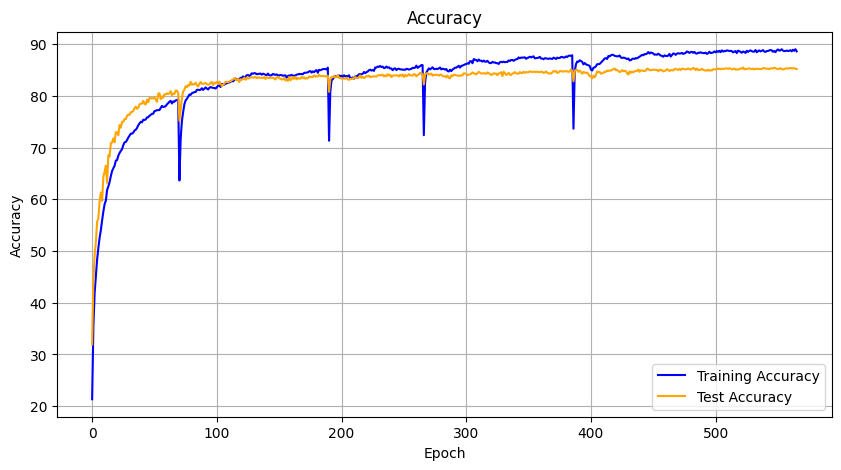

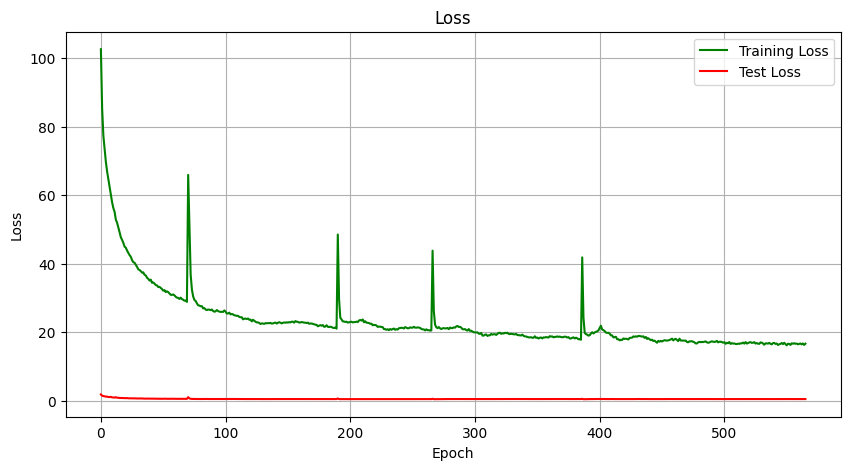

In [33]:
plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
            test_losses=test_losses,test_accuracy=test_accuracy)